In [399]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

import shapely.geometry as sg

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## ENSEMBLE QUANTILE for the mean of Satellites quantile

In [400]:
npix = 3

yy_s, yy_e = 2002, 2012
# yy_s, yy_e = 2002, 2023

year_vector = np.arange(yy_s, yy_e+1)
years_num = yy_e - yy_s + 1

# lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47
# # Test area 2
lon_min, lon_max, lat_min, lat_max = 11, 12.5, 45, 46.5

In [401]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

In [402]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [403]:
OBS_base = os.path.join(dir_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")
print(len(wa_pd))

205


## Concat Weibull Parameters

In [404]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


## Extract only interest years

In [405]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)
N_df.insert(3, 'Elv', wa_pd['Elv'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)
C_df.insert(3, 'Elv', wa_pd['Elv'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)
W_df.insert(3, 'Elv', wa_pd['Elv'].values)

print(len(W_df))

Extract Parameters for: 2002 to 2012
205


## Compute Quantiles

In [406]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
Q_obs = np.zeros([len(wa_pd), len(Tr)])
File_, Lat_, Lon_, Elev_, YYS_, YYE_, NY_ = [], [], [], [], [], [], []

for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    File_.append(wa_pd['File_Name'][nn])
    Lat_.append(wa_pd['Lat'][nn])
    Lon_.append(wa_pd['Lon'][nn])
    Elev_.append(wa_pd['Elv'][nn])
    YYS_.append(yy_s)
    YYE_.append(yy_e)
    NY_.append(years_num - np.sum(np.isnan(N_)))

    x0 = np.nanmean(C_)
    TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
    TMP_Q = np.where(flags==True,TMP_Q,np.nan)
    Q_obs[nn,:] = TMP_Q

new_df = pd.DataFrame(Q_obs, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'Elv', Elev_)
new_df.insert(4, 'YYS', YYS_)
new_df.insert(5, 'YYE', YYE_)
new_df.insert(6, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

print(len(clear_df))

166


In [407]:
lon_min_rect, lon_max_rect = lon_min, lon_max
lat_min_rect, lat_max_rect = lat_min, lat_max

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [408]:
frac = 0.8

Q_80 = clear_df.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = clear_df.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(clear_df)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 166
80% DataFrame: 133
20% DataFrame: 33


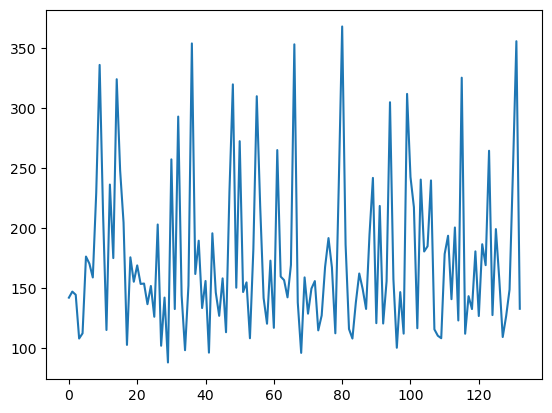

In [409]:
plt.plot(Q_80['Q50'])

## Continue with the analysis

In [410]:
# =============================================================================
wa_gdf = gpd.GeoDataFrame(clear_df, geometry=gpd.points_from_xy(clear_df['Lon'], clear_df['Lat']), crs="EPSG:4326")
wa_inside_rect = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect = wa_inside_rect.drop(columns=['index_right'])

# =============================================================================
wa_inside_rect = wa_inside_rect[wa_inside_rect['Q50']<=600]
wa_inside_rect = wa_inside_rect.reset_index(drop=True)

wa_inside_rect.sort_values(by=["Lat", "Lon"], ascending=[True, True], inplace=True)

# QOBS_area_mean = np.nanmean(wa_inside_rect.iloc[:,6:-1].values,axis=0)

print(len(wa_inside_rect))

137


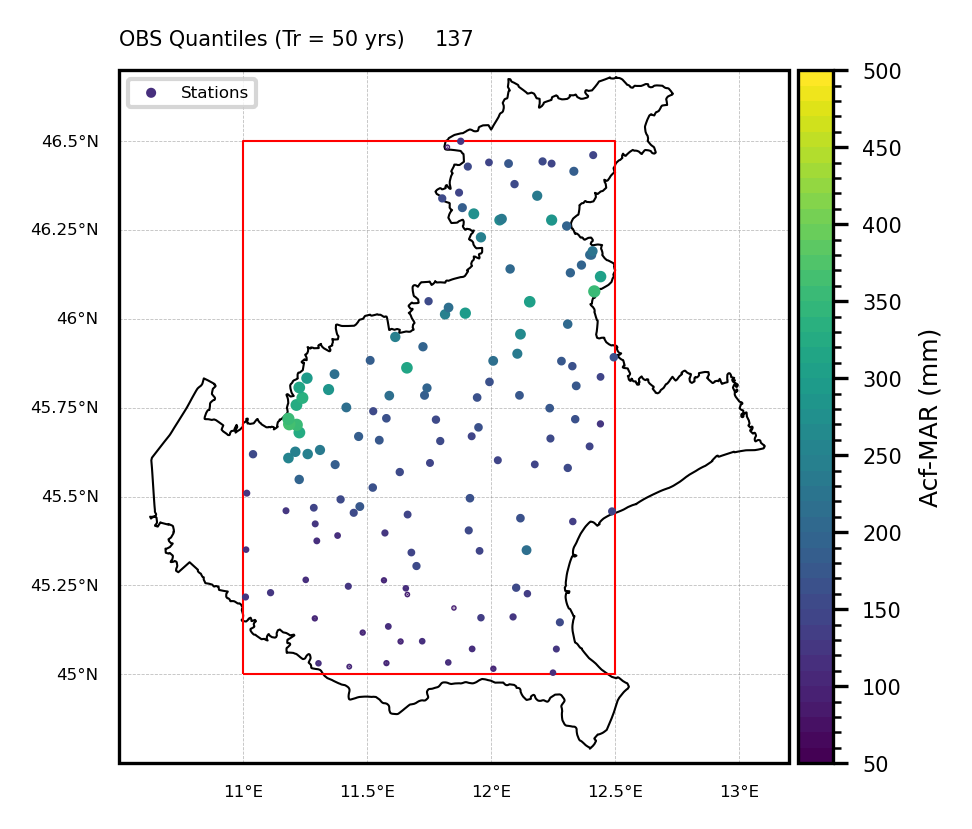

In [411]:
wa_inside_rect_norm = (wa_inside_rect['Q50']-wa_inside_rect['Q50'].min())/(wa_inside_rect['Q50'].max()-wa_inside_rect['Q50'].min())

levels_obs = np.arange(50,510,10)
norm_obs = mcolors.BoundaryNorm(boundaries=levels_obs, ncolors=256)

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.scatter(
                wa_inside_rect['Lon'].values, 
                wa_inside_rect['Lat'].values, 
                s=wa_inside_rect_norm*4, 
                c=wa_inside_rect['Q50'], 
                norm=norm_obs,
                zorder=20, label='Stations')

rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.5, zorder=15)

plt.legend(fontsize=4, loc=2)

cbar = plt.colorbar(a1, ticks= None, orientation='vertical', pad=0.01)
cbar.ax.tick_params(labelsize=5)
cbar.set_label("Acf-MAR (mm)", fontsize=6)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'OBS Quantiles (Tr = 50 yrs)', fontsize=5, loc='left')
ax1.set_title(f'{len(wa_inside_rect)}', fontsize=5, loc='center')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Satellite Data

In [364]:
acf = 'mar'

In [78]:
data_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

## IMERG

In [80]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_IMERG_1dy_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')
DATA = xr.open_dataset(data_dir)

lon_IMERG, lat_IMERG  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_IMERG, lats_IMERG = DATA.lon.values, DATA.lat.values

Tr = DATA['Tr'].values

NIMERG = DATA['NYs'].values
CIMERG = DATA['CYs'].values
WIMERG = DATA['WYs'].values

NdIMERG = DATA['NYd'].values
CdIMERG = DATA['CYd'].values
WdIMERG = DATA['WYd'].values

QIMERG = DATA.Mev_s.values
QdIMERG = DATA.Mev_d.values
del DATA
QIMERG.shape

(6, 15, 15)

## MSWEP

In [81]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_MSWEP_3h_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')

DATA = xr.open_dataset(data_dir)

lon_MSWEP, lat_MSWEP  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_MSWEP, lats_MSWEP = DATA.lon.values, DATA.lat.values

NMSWEP = DATA['NYs'].values
CMSWEP = DATA['CYs'].values
WMSWEP = DATA['WYs'].values

NdMSWEP = DATA['NYd'].values
CdMSWEP = DATA['CYd'].values
WdMSWEP = DATA['WYd'].values

QMSWEP = DATA.Mev_s.values
QdMSWEP = DATA.Mev_d.values
del DATA
QMSWEP.shape

(6, 15, 15)

## CMORPH

In [82]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_CMORPH_3h_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')

DATA = xr.open_dataset(data_dir)

lon_CMORPH, lat_CMORPH  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_CMORPH, lats_CMORPH = DATA.lon.values, DATA.lat.values

NCMORPH = DATA['NYs'].values
CCMORPH = DATA['CYs'].values
WCMORPH = DATA['WYs'].values

NdCMORPH = DATA['NYd'].values
CdCMORPH = DATA['CYd'].values
WdCMORPH = DATA['WYd'].values

QCMORPH = DATA.Mev_s.values
QdCMORPH = DATA.Mev_d.values
del DATA
QCMORPH.shape

(6, 6, 6)

## ERA5

In [83]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_ERA5_3h_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')

DATA = xr.open_dataset(data_dir)

lon_ERA5, lat_ERA5  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_ERA5, lats_ERA5 = DATA.lon.values, DATA.lat.values

NERA5 = DATA['NYs'].values
CERA5 = DATA['CYs'].values
WERA5 = DATA['WYs'].values

NdERA5 = DATA['NYd'].values
CdERA5 = DATA['CYd'].values
WdERA5 = DATA['WYd'].values

QERA5 = DATA.Mev_s.values
QdERA5 = DATA.Mev_d.values
# del DATA
QERA5.shape

(6, 7, 7)

## GSMaP

In [84]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_GSMaP_3h_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')

DATA = xr.open_dataset(data_dir)

lon_GSMaP, lat_GSMaP  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_GSMaP, lats_GSMaP = DATA.lon.values, DATA.lat.values

NGSMAP = DATA['NYs'].values
CGSMAP = DATA['CYs'].values
WGSMAP = DATA['WYs'].values

NdGSMAP = DATA['NYd'].values
CdGSMAP = DATA['CYd'].values
WdGSMAP = DATA['WYd'].values

QGSMaP = DATA.Mev_s.values
QdGSMaP = DATA.Mev_d.values
del DATA
QGSMaP.shape

(6, 15, 15)

## SM2RAIN

In [85]:
# data_dir = os.path.join(data_base,'3_DOWN',f'VENETO_DOWN_SM2RAIN_1dy_2007_2012_npix_5_{version}.nc')
# DATA = xr.open_dataset(data_dir)

# lon_SM2RAIN, lat_SM2RAIN  = np.meshgrid(DATA.lon.values, DATA.lat.values)
# lons_SM2RAIN, lats_SM2RAIN = DATA.lon.values, DATA.lat.values

# NSM2RAIN = DATA['N'].values
# CSM2RAIN = DATA['C'].values
# WSM2RAIN = DATA['W'].values

# NdSM2RAIN = DATA['Nd'].values
# CdSM2RAIN = DATA['Cd'].values
# WdSM2RAIN = DATA['Wd'].values

# QSM2RAIN = DATA.Q.values
# QdSM2RAIN = DATA.Qd.values
# # del DATA
# QSM2RAIN.shape

## PERSIANN

In [86]:
data_dir = os.path.join(data_base,'4_TEST',f'VENETO_DOWN_PERSIANN_1dy_2002_2012_npix_1_thr_1_acf_{acf}_ZOR_pearson.nc')

DATA = xr.open_dataset(data_dir)

lon_PERSIANN, lat_PERSIANN  = np.meshgrid(DATA.lon.values, DATA.lat.values)
lons_PERSIANN, lats_PERSIANN = DATA.lon.values, DATA.lat.values

NPERSIANN = DATA['NYs'].values
CPERSIANN = DATA['CYs'].values
WPERSIANN = DATA['WYs'].values

NdPERSIANN = DATA['NYd'].values
CdPERSIANN = DATA['CYd'].values
WdPERSIANN = DATA['WYd'].values

QPERSIANN = DATA.Mev_s.values
QdPERSIANN = DATA.Mev_d.values
# del DATA
QPERSIANN.shape

(6, 6, 6)

In [87]:
# Tr_index, Q_index = 0, 'Q5'
# Tr_index, Q_index = 1, 'Q10'
# Tr_index, Q_index = 2, 'Q20'
Tr_index, Q_index = 3, 'Q50'
# Tr_index, Q_index = 4, 'Q100'
# Tr_index, Q_index = 5, 'Q200'

colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange']

In [138]:
EQ_IMERG, EQ_CMORPH, EQ_MSWEP, EQ_ERA5, EQ_GSMaP, EQ_SM2RAIN, EQ_PERSIANN = [], [], [], [], [], [], []
EQd_IMERG, EQd_CMORPH, EQd_MSWEP, EQd_ERA5, EQd_GSMaP, EQd_SM2RAIN, EQd_PERSIANN = [], [], [], [], [], [], []
EQ_ESEMBLE, Q_SAT_list, EQd_ESEMBLE = [], [], []

for nn in range(len(wa_inside_rect)):
    Q_OBS = wa_inside_rect[Q_index].values[nn]
    lat_obs = wa_inside_rect['Lat'].values[nn]
    lon_obs = wa_inside_rect['Lon'].values[nn]
    elv_obs = wa_inside_rect['Elv'].values[nn]

    # ==============================================================================
    # IMERG
    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    IMERG_Q = QIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Q - Q_OBS)/Q_OBS
    EQ_IMERG.append(float(EQ))
    
    IMERG_Qd = QdIMERG[Tr_index,min_index[0],min_index[1]]
    EQ = (IMERG_Qd - Q_OBS)/Q_OBS
    EQd_IMERG.append(float(EQ))

    # ==============================================================================
    # CMORPH
    distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    CMORPH_Q = QCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Q - Q_OBS)/Q_OBS
    EQ_CMORPH.append(float(EQ))

    CMORPH_Qd = QdCMORPH[Tr_index,min_index[0],min_index[1]]
    EQ = (CMORPH_Qd - Q_OBS)/Q_OBS
    EQd_CMORPH.append(float(EQ))

    # ==============================================================================
    # MSWEP
    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    MSWEP_Q = QMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Q - Q_OBS)/Q_OBS
    EQ_MSWEP.append(float(EQ))
    
    MSWEP_Qd = QdMSWEP[Tr_index,min_index[0],min_index[1]]
    EQ = (MSWEP_Qd - Q_OBS)/Q_OBS
    EQd_MSWEP.append(float(EQ))

    # ==============================================================================
    # ERA5
    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    ERA5_Q = QERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Q - Q_OBS)/Q_OBS
    EQ_ERA5.append(float(EQ))
    
    ERA5_Qd = QdERA5[Tr_index,min_index[0],min_index[1]]
    EQ = (ERA5_Qd - Q_OBS)/Q_OBS
    EQd_ERA5.append(float(EQ))

    # ==============================================================================
    # GSMaP
    distances = ART_pre.haversine(lat_GSMaP, lon_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    GSMaP_Q = QGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Q - Q_OBS)/Q_OBS
    EQ_GSMaP.append(float(EQ))
    
    GSMaP_Qd = QdGSMaP[Tr_index,min_index[0],min_index[1]]
    EQ = (GSMaP_Qd - Q_OBS)/Q_OBS
    EQd_GSMaP.append(float(EQ))

    # # ==============================================================================
    # # SM2RAIN
    # distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    # SM2RAIN_Q = QSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Q - Q_OBS)/Q_OBS
    # EQ_SM2RAIN.append(float(EQ))
    
    # SM2RAIN_Qd = QdSM2RAIN[Tr_index,min_index[0],min_index[1]]
    # EQ = (SM2RAIN_Qd - Q_OBS)/Q_OBS
    # EQd_SM2RAIN.append(float(EQ))

    # ==============================================================================
    # PERSIANN
    distances = ART_pre.haversine(lat_PERSIANN, lon_PERSIANN, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    
    PERSIANN_Q = QPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Q - Q_OBS)/Q_OBS
    EQ_PERSIANN.append(float(EQ))
    
    PERSIANN_Qd = QdPERSIANN[Tr_index,min_index[0],min_index[1]]
    EQ = (PERSIANN_Qd - Q_OBS)/Q_OBS
    EQd_PERSIANN.append(float(EQ))

    # ==============================================================================
    SAT_ENSEMBLE_Q = np.nanmean(
                        [
                        IMERG_Q,
                        CMORPH_Q,
                        MSWEP_Q,
                        ERA5_Q,
                        GSMaP_Q,
                        # SM2RAIN_Qd,
                        PERSIANN_Qd
                        ])
    EQ_ESEMBLE_ = (SAT_ENSEMBLE_Q - Q_OBS)/Q_OBS
    EQ_ESEMBLE.append(EQ_ESEMBLE_)
    
    SAT_ENSEMBLE_Qd = np.nanmean(
                        [
                        IMERG_Qd,
                        CMORPH_Qd,
                        MSWEP_Qd,
                        ERA5_Qd,
                        GSMaP_Qd,
                        # SM2RAIN_Qd,
                        PERSIANN_Qd
                        ])
    EQd_ESEMBLE_ = (SAT_ENSEMBLE_Qd - Q_OBS)/Q_OBS
    EQd_ESEMBLE.append(EQd_ESEMBLE_)

    Q_SAT_list.append({
        'Lat': lat_obs,
        'Lon': lon_obs,
        'Elv':elv_obs,
        'OBS': Q_OBS,
        'IMERG': IMERG_Q,
        'IMERGd': IMERG_Qd,
        'CMORPH': CMORPH_Q,
        'CMORPHd': CMORPH_Qd,
        'MSWEP': MSWEP_Q,
        'MSWEPd': MSWEP_Qd,
        'ERA5': ERA5_Q,
        'ERA5d': ERA5_Qd,
        'GSMaP': GSMaP_Q,
        'GSMaPd': GSMaP_Qd,
        # 'SM2RAIN': SM2RAIN_Q,
        # 'SM2RAINd': SM2RAIN_Qd,
        'PERSIANN':PERSIANN_Q,
        'PERSIANNd':PERSIANN_Qd,
        'ENSEMBLE': SAT_ENSEMBLE_Q,
        'ENSEMBLEd': SAT_ENSEMBLE_Qd
    })

SATELLITE_pd = pd.DataFrame(Q_SAT_list)

Text(1.0, 1.0, '2002 to 2012')

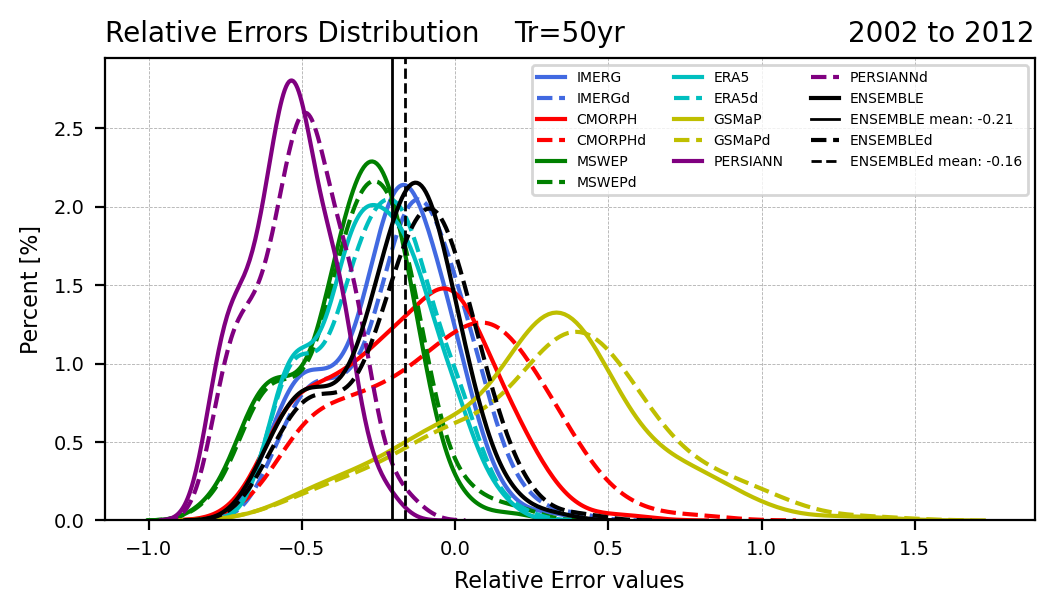

In [139]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(EQ_IMERG,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERG')
sns.kdeplot(EQd_IMERG,color=colors[0], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'IMERGd')

sns.kdeplot(EQ_CMORPH,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPH')
sns.kdeplot(EQd_CMORPH,color=colors[1], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'CMORPHd')

sns.kdeplot(EQ_MSWEP,color=colors[2],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEP')
sns.kdeplot(EQd_MSWEP,color=colors[2], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'MSWEPd')

sns.kdeplot(EQ_ERA5,color=colors[3],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5')
sns.kdeplot(EQd_ERA5,color=colors[3], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ERA5d')

sns.kdeplot(EQ_GSMaP,color=colors[4],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaP')
sns.kdeplot(EQd_GSMaP,color=colors[4], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'GSMaPd')

sns.kdeplot(EQ_PERSIANN,color=colors[5],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANN')
sns.kdeplot(EQd_PERSIANN,color=colors[5], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'PERSIANNd')

# sns.kdeplot(EQ_SM2RAIN,color=colors[6],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAIN')
# sns.kdeplot(EQd_PERSIANN,color=colors[6], linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'SM2RAINd')

sns.kdeplot(EQ_ESEMBLE,color='k',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE')
ax1.axvline(np.mean(EQ_ESEMBLE),color='k',linestyle='-',linewidth=1, label=f'ENSEMBLE mean: {np.round(np.nanmean(np.mean(EQ_ESEMBLE)),2)}')

sns.kdeplot(EQd_ESEMBLE,color='k', linestyle='--',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLEd')
ax1.axvline(np.mean(EQd_ESEMBLE),color='k',linestyle='--',linewidth=1, label=f'ENSEMBLEd mean: {np.round(np.nanmean(np.mean(EQd_ESEMBLE)),2)}')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=0, ncol=3)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=7)
ax1.set_title('Relative Errors Distribution', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

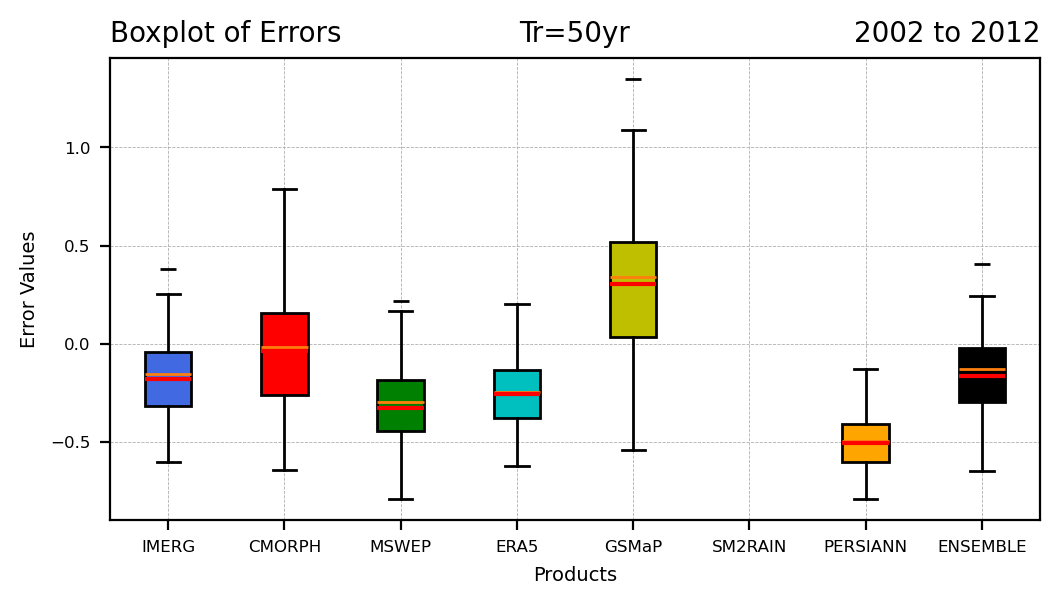

In [140]:
fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

boxes = []
medians = []
mean = []
fliers = []

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

box = ax1.boxplot(np.array(EQd_IMERG)[~np.isnan(EQd_IMERG)],positions=[0],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[0],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_CMORPH)[~np.isnan(EQd_CMORPH)],positions=[1],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[1],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_MSWEP)[~np.isnan(EQd_MSWEP)],positions=[2],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[2],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_ERA5)[~np.isnan(EQd_ERA5)],positions=[3],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[3],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_GSMaP)[~np.isnan(EQd_GSMaP)],positions=[4],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[4],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_SM2RAIN)[~np.isnan(EQd_SM2RAIN)],positions=[5],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[5],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_PERSIANN)[~np.isnan(EQd_PERSIANN)],positions=[6],vert=True,
    widths=0.4,boxprops=dict(facecolor=colors[6],color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

box = ax1.boxplot(np.array(EQd_ESEMBLE)[~np.isnan(EQd_ESEMBLE)],positions=[7],vert=True,
    widths=0.4,boxprops=dict(facecolor='k',color='k'),
    showmeans=True,meanline=True,meanprops=dict(linestyle='-',color="r",linewidth=1.5),
    showfliers=True,flierprops=dict(marker='_',color='k',linewidth=1.5),
    patch_artist=True,notch=False)

ax1.set_xticks([0,1,2,3,4,5,6,7])
ax1.set_xticklabels(['IMERG','CMORPH','MSWEP','ERA5','GSMaP','SM2RAIN', 'PERSIANN', 'ENSEMBLE'],fontsize=6)
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_xlabel('Products',fontsize=7)
ax1.set_ylabel('Error Values',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('Boxplot of Errors', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[Tr_index]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')

ax1.set_facecolor('white')
fig.patch.set_alpha(0)

In [101]:
E_IMERG_M = np.ones_like(QdIMERG[0,:,:])*np.nan
# E_CMORPH_M = np.ones_like(QdCMORPH[0,:,:])*np.nan
E_MSWEP_M = np.ones_like(QdMSWEP[0,:,:])*np.nan
E_ERA5_M = np.ones_like(QdERA5[0,:,:])*np.nan
E_GSMaP_M = np.ones_like(QdGSMaP[0,:,:])*np.nan
# E_SM2RAIN_M = np.ones_like(QdSM2RAIN[0,:,:])*np.nan
E_ENSEMBLE_M = np.ones_like(QdIMERG[0,:,:])*np.nan

for nn in range(len(wa_inside_rect)):
    Q_OBS = wa_inside_rect[Q_index].values[nn]
    lat_obs = wa_inside_rect['Lat'].values[nn]
    lon_obs = wa_inside_rect['Lon'].values[nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_IMERG_M[min_index[0],min_index[1]] = 100*(QdIMERG[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    # distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # E_CMORPH_M[min_index[0],min_index[1]] = 100*(QdCMORPH[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_MSWEP_M[min_index[0],min_index[1]] = 100*(QdMSWEP[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_ERA5_M[min_index[0],min_index[1]] = 100*(QdERA5[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    distances = ART_pre.haversine(lat_GSMaP, lon_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    E_GSMaP_M[min_index[0],min_index[1]] = 100*(QdGSMaP[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

    # distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # E_SM2RAIN_M[min_index[0],min_index[1]] = 100*(QdSM2RAIN[Tr_index,min_index[0],min_index[1]]-Q_OBS)/Q_OBS

In [102]:
products = ['IMERGd', 'CMORPHd', 'MSWEPd', 'ERA5d', 'GSMaPd', 'PERSIANNd', 'ENSEMBLE', 'ENSEMBLEd']
letter = ['(a)','(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

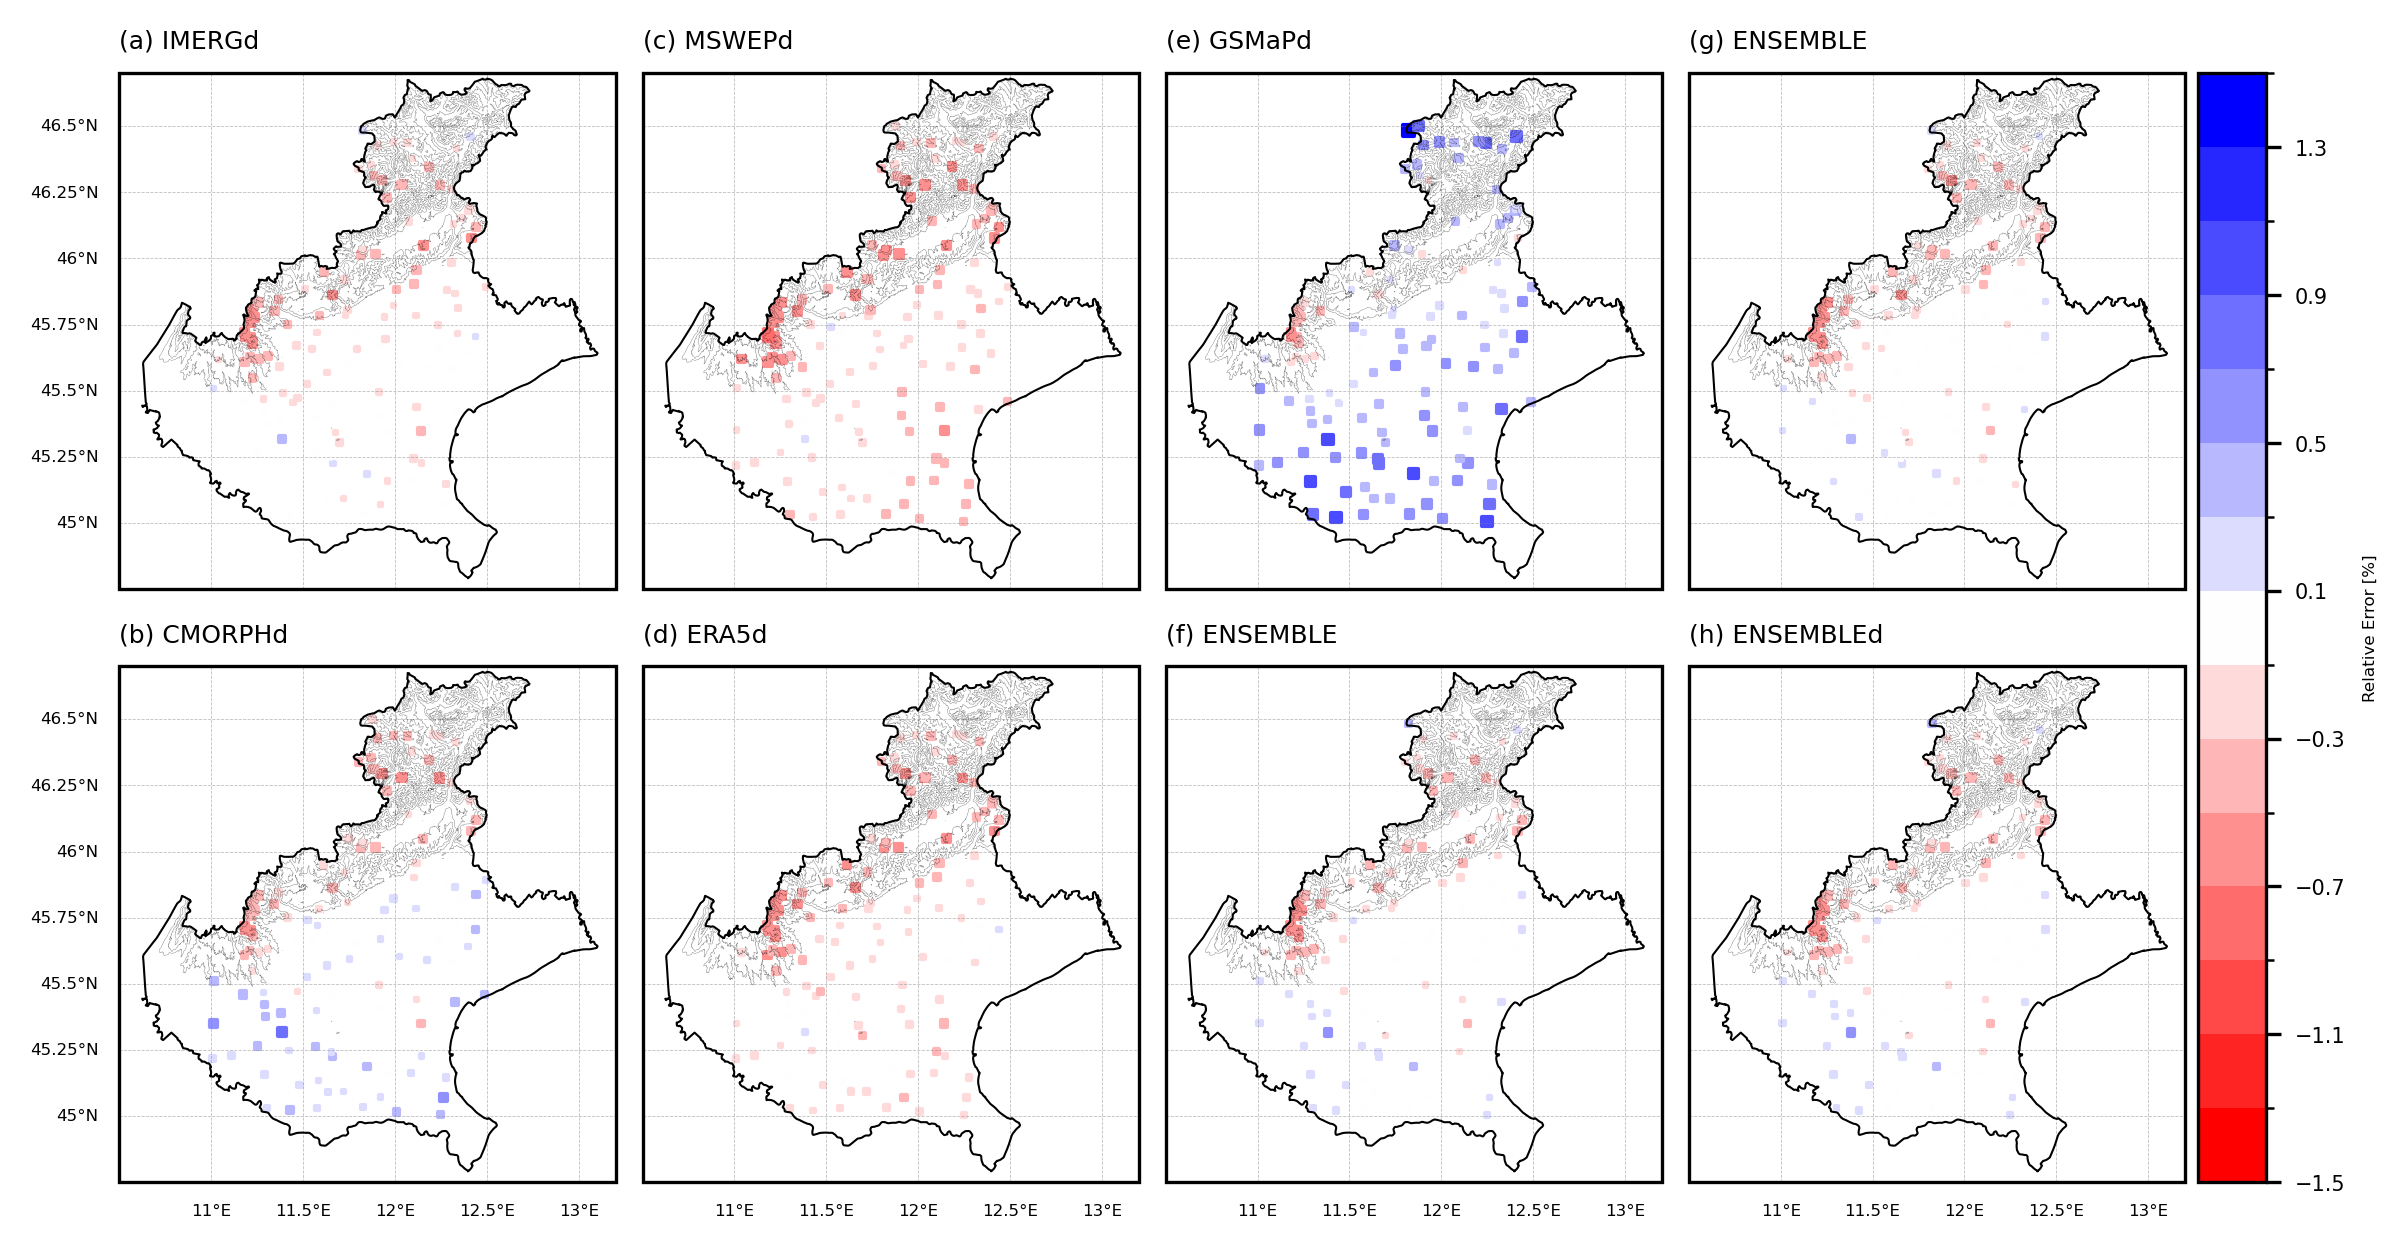

In [94]:
# levels = np.arange(-2,2.2,0.2)
levels = np.arange(-1.5,1.7,0.2)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# ticks = np.arange(-1,1.4,0.4)

# levels = np.arange(-100,110,10)
# norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
# ticks = np.arange(-100,140,40)

cmap = plt.cm.Spectral_r
cmap = plt.cm.bwr_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(9,4.8),dpi=300)
gs = gridspec.GridSpec(2,4)

# ==============================================================================
pos = 0
count = 1
for ncol in range(4):#3
    for nrow in range(2):
        ax_name = f"ax{count}"
        globals()[ax_name] = plt.subplot(gs[nrow, ncol], projection=proj)
        globals()[ax_name].set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
        VENETO.plot(facecolor='None', ax=globals()[ax_name], linewidth=0.5, zorder=10)
        DEM.plot(facecolor='None', ax=globals()[ax_name], zorder=10, linewidth=0.1, color='k', alpha=0.5)
        
        if nrow == 1 and ncol == 2:
            a1 = globals()[ax_name].scatter(SATELLITE_pd['Lon'],
                SATELLITE_pd['Lat'],
                s=abs((SATELLITE_pd['ENSEMBLEd']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS'])*5,
                c=((SATELLITE_pd['ENSEMBLEd']-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']),
                marker='s',
                cmap=cmap, norm=norm)
        
        else:
            # print(products[pos])
            a1 = globals()[ax_name].scatter(SATELLITE_pd['Lon'],
                SATELLITE_pd['Lat'],
                s=abs((SATELLITE_pd[products[pos]]-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS'])*5,
                c=((SATELLITE_pd[products[pos]]-SATELLITE_pd['OBS'])/SATELLITE_pd['OBS']),
                marker='s',
                cmap=cmap, norm=norm)

        gl = globals()[ax_name].gridlines(crs=proj,draw_labels=False,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
        if ncol == 0:
            gl.left_labels = True
        else:
            gl.left_labels = False
        if nrow == 0:
            gl.bottom_labels = False
        else:
            gl.bottom_labels = True
        gl.xlabel_style = {'size': 4, 'color': 'k'}
        gl.ylabel_style = {'size': 4, 'color': 'k'}

        # globals()[ax_name].set_title(f"{letter[pos]} {products[pos]}", fontsize=6, loc='left')
        
        if pos ==5:
            globals()[ax_name].set_title(f"(f) ENSEMBLE", fontsize=6, loc='left')
        else:
            globals()[ax_name].set_title(f"{letter[pos]} {products[pos]}", fontsize=6, loc='left')
        
        # cbar = plt.colorbar(a1, ticks=ticks, fraction=0.053)
        # cbar.set_label('Relative Error [%]',fontsize=4)
        # cbar.ax.tick_params(labelsize=4)

        count += 1
        pos += 1
# ==============================================================================
# ax1.set_title(f'Relative Error', fontsize=6, loc='right')
cbar_ax = fig.add_axes([0.9, 0.11, 0.025, 0.77])#0.91
cbar = plt.colorbar(a1, cax=cbar_ax, ticks= None, orientation='vertical')
cbar.set_label('Relative Error [%]',fontsize=4)
cbar.ax.tick_params(labelsize=5)

# ==============================================================================
plt.subplots_adjust(wspace=0, hspace=0.15)
ax1.set_facecolor('white')
# fig.patch.set_alpha(0)

In [299]:
SATELLITE_sorted = SATELLITE_pd.sort_values(by='Elv').reset_index(drop=True)
q25, q50, q75 = np.percentile(SATELLITE_sorted['Elv'], [25, 50, 75])
print(f"Low        : < {q25:.2f}")
print(f"Medium-low : {q25:.2f} - {q50:.2f}")
print(f"Medium-high: {q50:.2f} - {q75:.2f}")
print(f"High       : > {q75:.2f}")

SATELLITE_sorted['Elv_group'] = pd.qcut(
    SATELLITE_sorted['Elv'], 
    q=4, 
    labels=['Low', 'Medium-low', 'Medium-high', 'High']
)

Low        : < 17.00
Medium-low : 17.00 - 123.00
Medium-high: 123.00 - 650.00
High       : > 650.00


In [300]:
group_mapping1 = {
    'Low': 1,
    'Medium-low': 2,
    'Medium-high': 3,
    'High': 4
}
SATELLITE_sorted['Elv_group_num'] = SATELLITE_sorted['Elv_group'].map(group_mapping1)

group_mapping2 = {
    'Low': '#edf8e9',
    'Medium-low': '#bae4b3',
    'Medium-high': '#74c476',
    'High': '#238b45'
}
SATELLITE_sorted['Elv_group_color'] = SATELLITE_sorted['Elv_group'].map(group_mapping2)

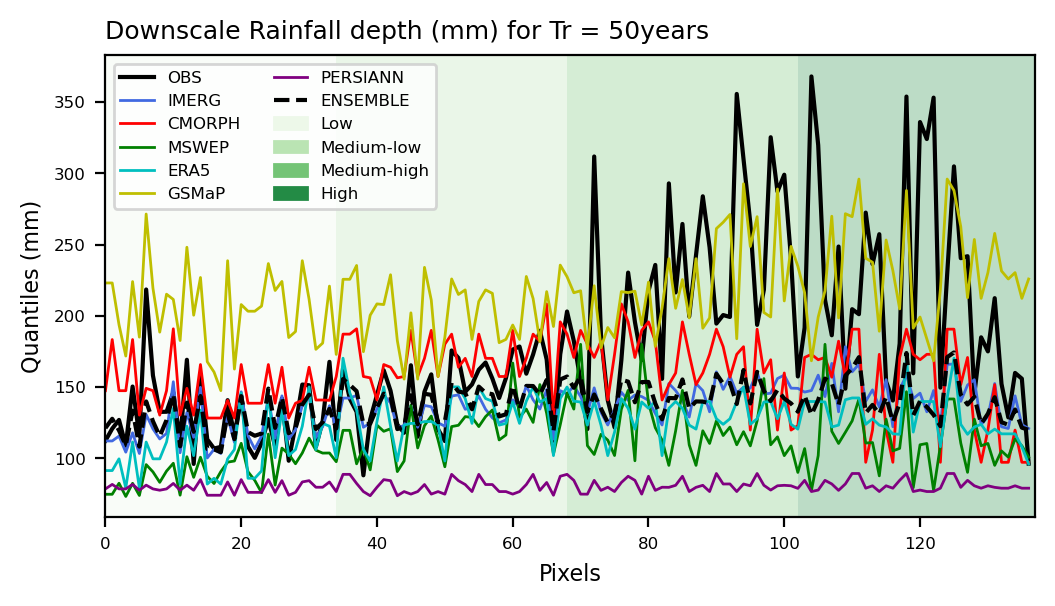

In [301]:
# Definir colores para cada grupo
group_colors = {
    'Low': '#edf8e9',
    'Medium-low': '#bae4b3',
    'Medium-high': '#74c476',
    'High': '#238b45'
}

fig = plt.figure(figsize=(6, 3), dpi=200)
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0, 0])

n = len(SATELLITE_sorted)
step = n // 4

for i, (label, color) in enumerate(group_colors.items()):
    start = i * step
    end = (i + 1) * step if i < 3 else n  # el último grupo llega hasta el final
    ax1.axvspan(start, end, facecolor=color, alpha=0.3)

line_obs, = ax1.plot(SATELLITE_sorted['OBS'].values, color='k', linewidth=1.5, label='OBS')

line_IMERGd, = ax1.plot(SATELLITE_sorted['IMERGd'].values, color=colors[0], linewidth=1, label='IMERG')
line_CMORPHd, = ax1.plot(SATELLITE_sorted['CMORPHd'].values, color=colors[1], linewidth=1, label='CMORPH')
line_MSWEPd, = ax1.plot(SATELLITE_sorted['MSWEPd'].values, color=colors[2], linewidth=1, label='MSWEP')
line_ERA5d, = ax1.plot(SATELLITE_sorted['ERA5d'].values, color=colors[3], linewidth=1, label='ERA5')
line_GSMaPd, = ax1.plot(SATELLITE_sorted['GSMaPd'].values, color=colors[4], linewidth=1, label='GSMaP')
line_PERSIANNd, = ax1.plot(SATELLITE_sorted['PERSIANNd'].values, color=colors[5], linewidth=1, label='PERSIANN')

line_ENSEMBLEd, = ax1.plot(SATELLITE_sorted['ENSEMBLEd'], '--k', linewidth=1.5, label='ENSEMBLE', zorder=20)

plt.ylabel('Quantiles (mm)',fontsize=8)
plt.xlabel('Pixels',fontsize=8)
plt.title('Downscale Rainfall depth (mm) for Tr = 50years',fontsize=9, loc='left')

patches = [Patch(color=color, label=label) for label, color in group_colors.items()]

ax1.legend(
    handles=[line_obs,line_IMERGd,line_CMORPHd,line_MSWEPd,line_ERA5d,line_GSMaPd,line_PERSIANNd,line_ENSEMBLEd] + patches, 
    fontsize=6, ncol=2)

plt.xlim(0, len(SATELLITE_sorted['OBS'].values))
ax1.tick_params(axis='both', which='major', labelsize=6)

In [302]:
window_size = 10
OBS_smoothed = SATELLITE_sorted['OBS'].rolling(window=window_size, center=True).mean()
IMERG_smoothed = SATELLITE_sorted['IMERGd'].rolling(window=window_size, center=True).mean()
CMORPH_smoothed = SATELLITE_sorted['CMORPHd'].rolling(window=window_size, center=True).mean()
MSWEP_smoothed = SATELLITE_sorted['MSWEPd'].rolling(window=window_size, center=True).mean()
ERA5_smoothed = SATELLITE_sorted['ERA5d'].rolling(window=window_size, center=True).mean()
GSMaP_smoothed = SATELLITE_sorted['GSMaPd'].rolling(window=window_size, center=True).mean()
PERSIANN_smoothed = SATELLITE_sorted['PERSIANNd'].rolling(window=window_size, center=True).mean()
ENSEMBLEd_smoothed = SATELLITE_sorted['ENSEMBLEd'].rolling(window=window_size, center=True).mean()

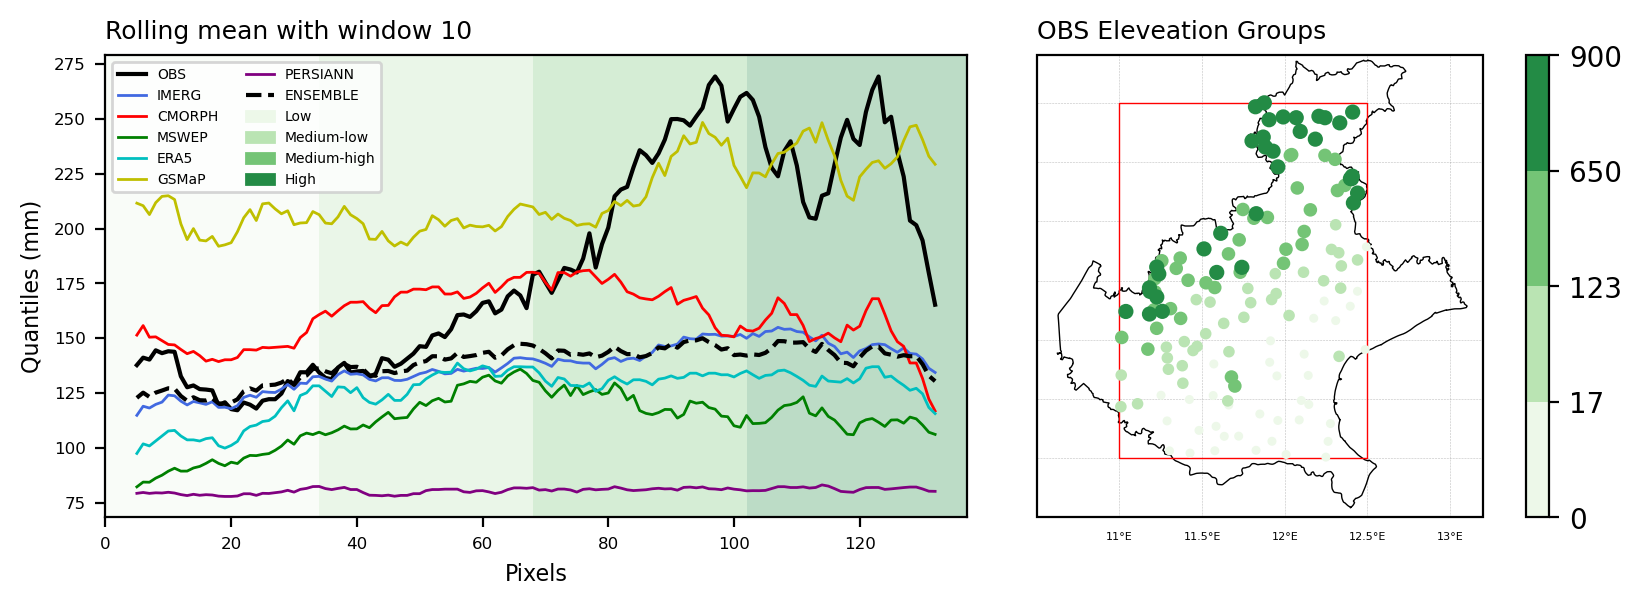

In [326]:
group_colors_list = ['#edf8e9', '#bae4b3', '#74c476', '#238b45']
cmap_elv = mcolors.ListedColormap(group_colors_list)

fig = plt.figure(figsize=(10, 3), dpi=200)
gs = gridspec.GridSpec(1, 2)

# ==================================================================================
ax1 = plt.subplot(gs[0, 0])
for i, (label, color) in enumerate(group_colors.items()):
    start = i * step
    end = (i + 1) * step if i < 3 else n  # el último grupo llega hasta el final
    ax1.axvspan(start, end, facecolor=color, alpha=0.3)

# ax1.plot(SATELLITE_sorted['OBS'].values, color='k', linewidth=1.5, label='OBS')
line_obs, = ax1.plot(OBS_smoothed, color='k', linewidth=1.5, label='OBS')
line_IMERGd, = ax1.plot(IMERG_smoothed, color=colors[0], linewidth=1, label='IMERG')
line_CMORPHd, = ax1.plot(CMORPH_smoothed, color=colors[1], linewidth=1, label='CMORPH')
line_MSWEPd, = ax1.plot(MSWEP_smoothed, color=colors[2], linewidth=1, label='MSWEP')
line_ERA5d, = ax1.plot(ERA5_smoothed, color=colors[3], linewidth=1, label='ERA5')
line_GSMaPd, = ax1.plot(GSMaP_smoothed, color=colors[4], linewidth=1, label='GSMaP')
line_PERSIANNd, = ax1.plot(PERSIANN_smoothed, color=colors[5], linewidth=1, label='PERSIANN')
line_ENSEMBLEd, = ax1.plot(ENSEMBLEd_smoothed, '--k', linewidth=1.5, label='ENSEMBLE', zorder=20)

plt.ylabel('Quantiles (mm)', fontsize=8)
plt.xlabel('Pixels', fontsize=8)
plt.title('Rolling mean with window 10', fontsize=9, loc='left')
plt.xlim(0, len(SATELLITE_sorted['OBS'].values))

patches = [Patch(color=color, label=label) for label, color in group_colors.items()]
ax1.legend(
    handles=[line_obs,line_IMERGd,line_CMORPHd,line_MSWEPd,line_ERA5d,line_GSMaPd,line_PERSIANNd,line_ENSEMBLEd] + patches, 
    fontsize=5, ncol=2)

ax1.tick_params(axis='both', which='major', labelsize=6)

# ==================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.75, 46.7],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

scatter = scatter = ax1.scatter(
    SATELLITE_sorted['Lon'],
    SATELLITE_sorted['Lat'],
    s=abs(np.array(SATELLITE_sorted['Elv_group_num'].values))*5,  # Tamaño del punto
    c=np.array(SATELLITE_sorted['Elv_group_num'].values),       # Color del punto
    cmap=cmap_elv,
    zorder=20
)

rect_gdf.plot(ax=ax1, edgecolor='r', facecolor='none', linewidth=0.5, zorder=15)

cbar = plt.colorbar(scatter, ax=ax1, orientation='vertical')
cbar.set_ticks([1, 1.75, 2.5, 3.25,4])
cbar.set_ticklabels(['0', '17', '123', '650', '900']) 

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels =False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title(f'OBS Eleveation Groups', fontsize=9, loc='left')

plt.subplots_adjust(wspace=-0.2, hspace=0)

In [327]:
Q_IMERG_list = []
Q_CMORPH_list = []
Q_MSWEP_list = []
Q_ERA5_list = []
Q_GSMaP_list = []
Q_SM2RAIN_list = []
for nn in range(len(wa_inside_rect)):
    lat_obs = wa_inside_rect['Lat'].values[nn]
    lon_obs = wa_inside_rect['Lon'].values[nn]

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_IMERG_list.append(float(QdIMERG[Tr_index,min_index[0],min_index[1]]))
    
    # distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # Q_CMORPH_list.append(QdCMORPH[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_MSWEP_list.append(QdMSWEP[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_ERA5_list.append(QdERA5[Tr_index,min_index[0],min_index[1]])

    distances = ART_pre.haversine(lat_GSMaP, lon_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    Q_GSMaP_list.append(QdGSMaP[Tr_index,min_index[0],min_index[1]])

    # distances = ART_pre.haversine(lat_SM2RAIN, lon_SM2RAIN, lat_obs, lon_obs)
    # min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
    # Q_SM2RAIN_list.append(QdSM2RAIN[Tr_index,min_index[0],min_index[1]])

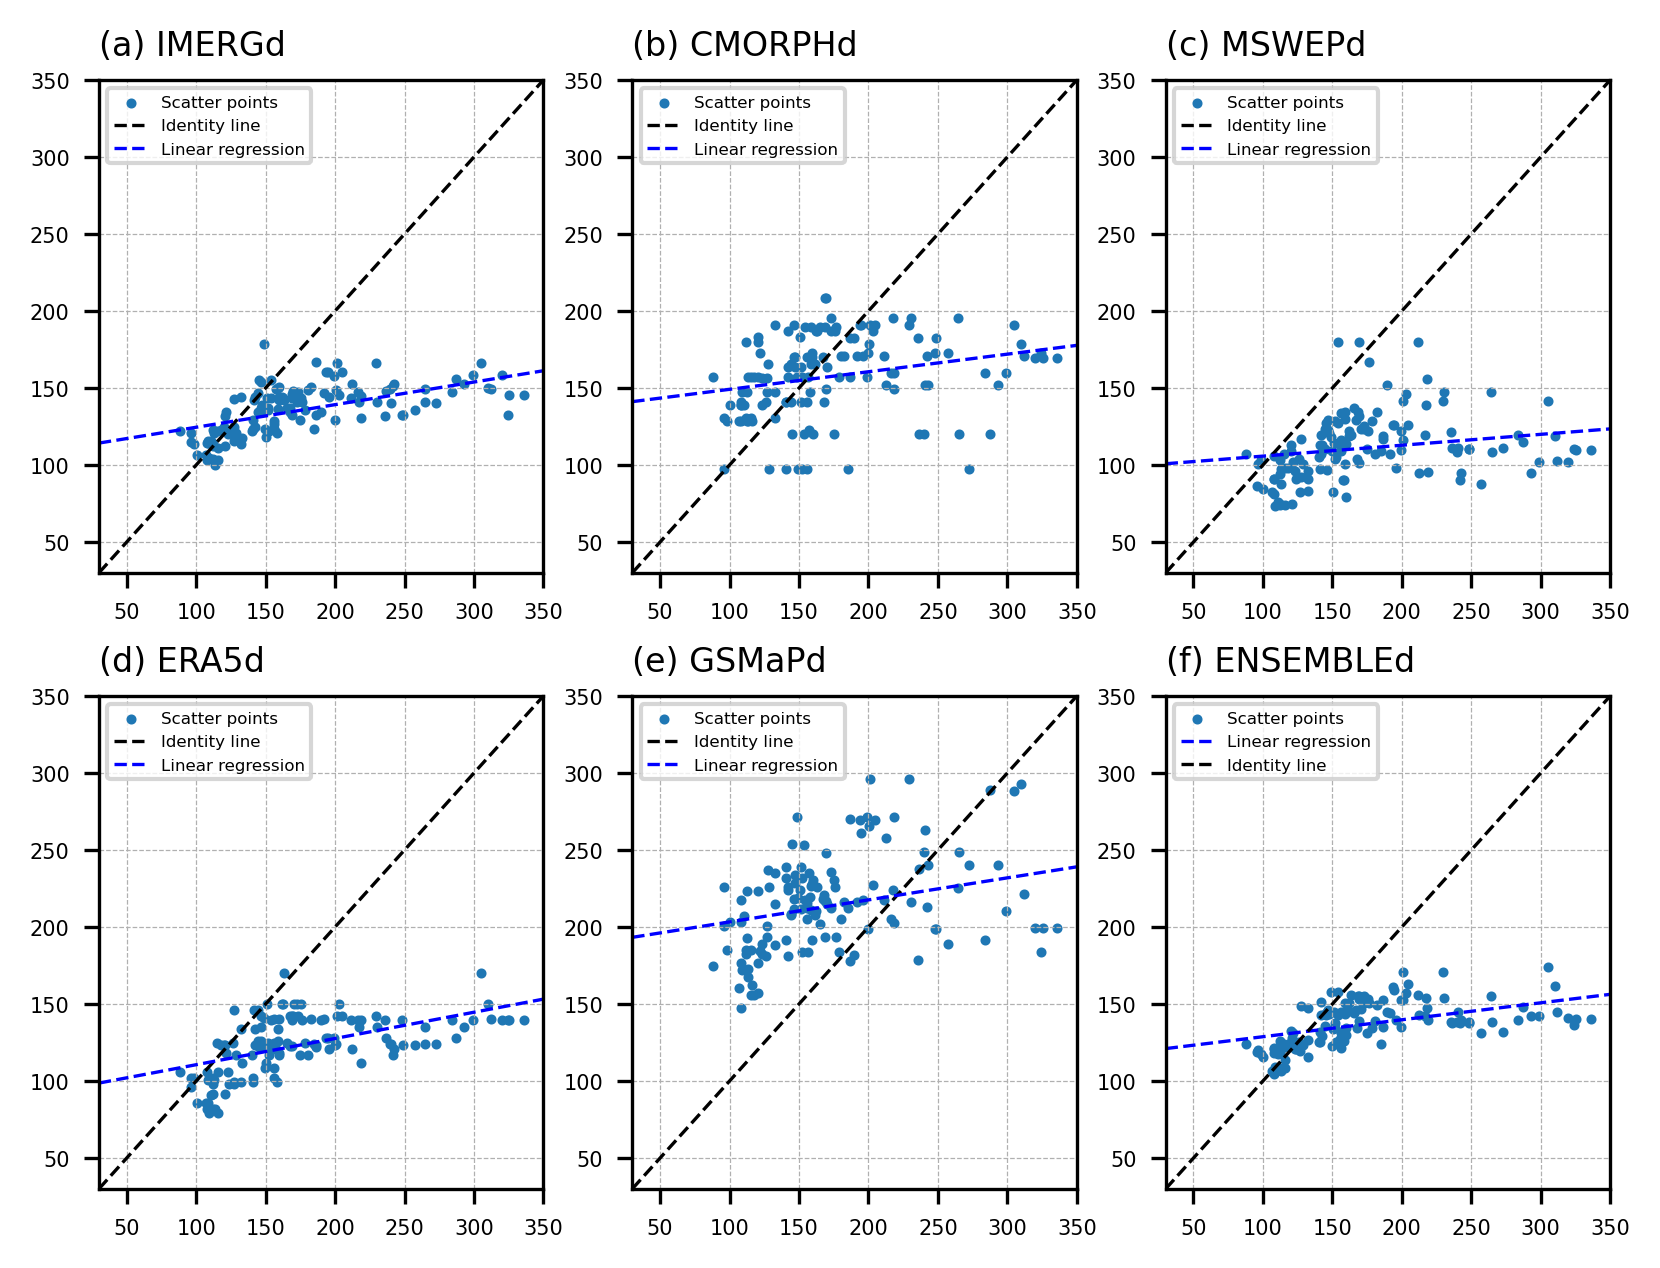

In [328]:
lmin, lmax = 30, 350

xx = np.arange(lmin,lmax+10,10)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['IMERGd'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['IMERGd'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['IMERGd'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['IMERGd'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERGd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['CMORPHd'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['CMORPHd'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['CMORPHd'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['CMORPHd'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPHd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['MSWEPd'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['MSWEPd'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['MSWEPd'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['MSWEPd'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEPd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['ERA5d'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['ERA5d'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['ERA5d'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['ERA5d'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5d', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['GSMaPd'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['GSMaPd'])])
ax1.scatter(SATELLITE_pd['OBS'], SATELLITE_pd['GSMaPd'], s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(SATELLITE_pd['OBS'], SATELLITE_pd['GSMaPd'])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) GSMaPd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
max_val = np.max([
                np.nanmax(SATELLITE_pd['OBS']),
                np.nanmax(SATELLITE_pd['ENSEMBLEd'])])
min_val = np.min([
                np.nanmin(SATELLITE_pd['OBS']),
                np.nanmin(SATELLITE_pd['ENSEMBLEd'])])
a = np.array(SATELLITE_pd['OBS'])[np.array(SATELLITE_pd['ENSEMBLEd'])!=0]
b = np.array(SATELLITE_pd['ENSEMBLEd'])[np.array(SATELLITE_pd['ENSEMBLEd'])!=0]
ax1.scatter(a, b, s=2, label='Scatter points')
slope, intercept, _, _, _ = stats.linregress(a[~np.isnan(b)], b[~np.isnan(b)])
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')
ax1.set_title('(f) ENSEMBLEd', fontsize=8, loc='left')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

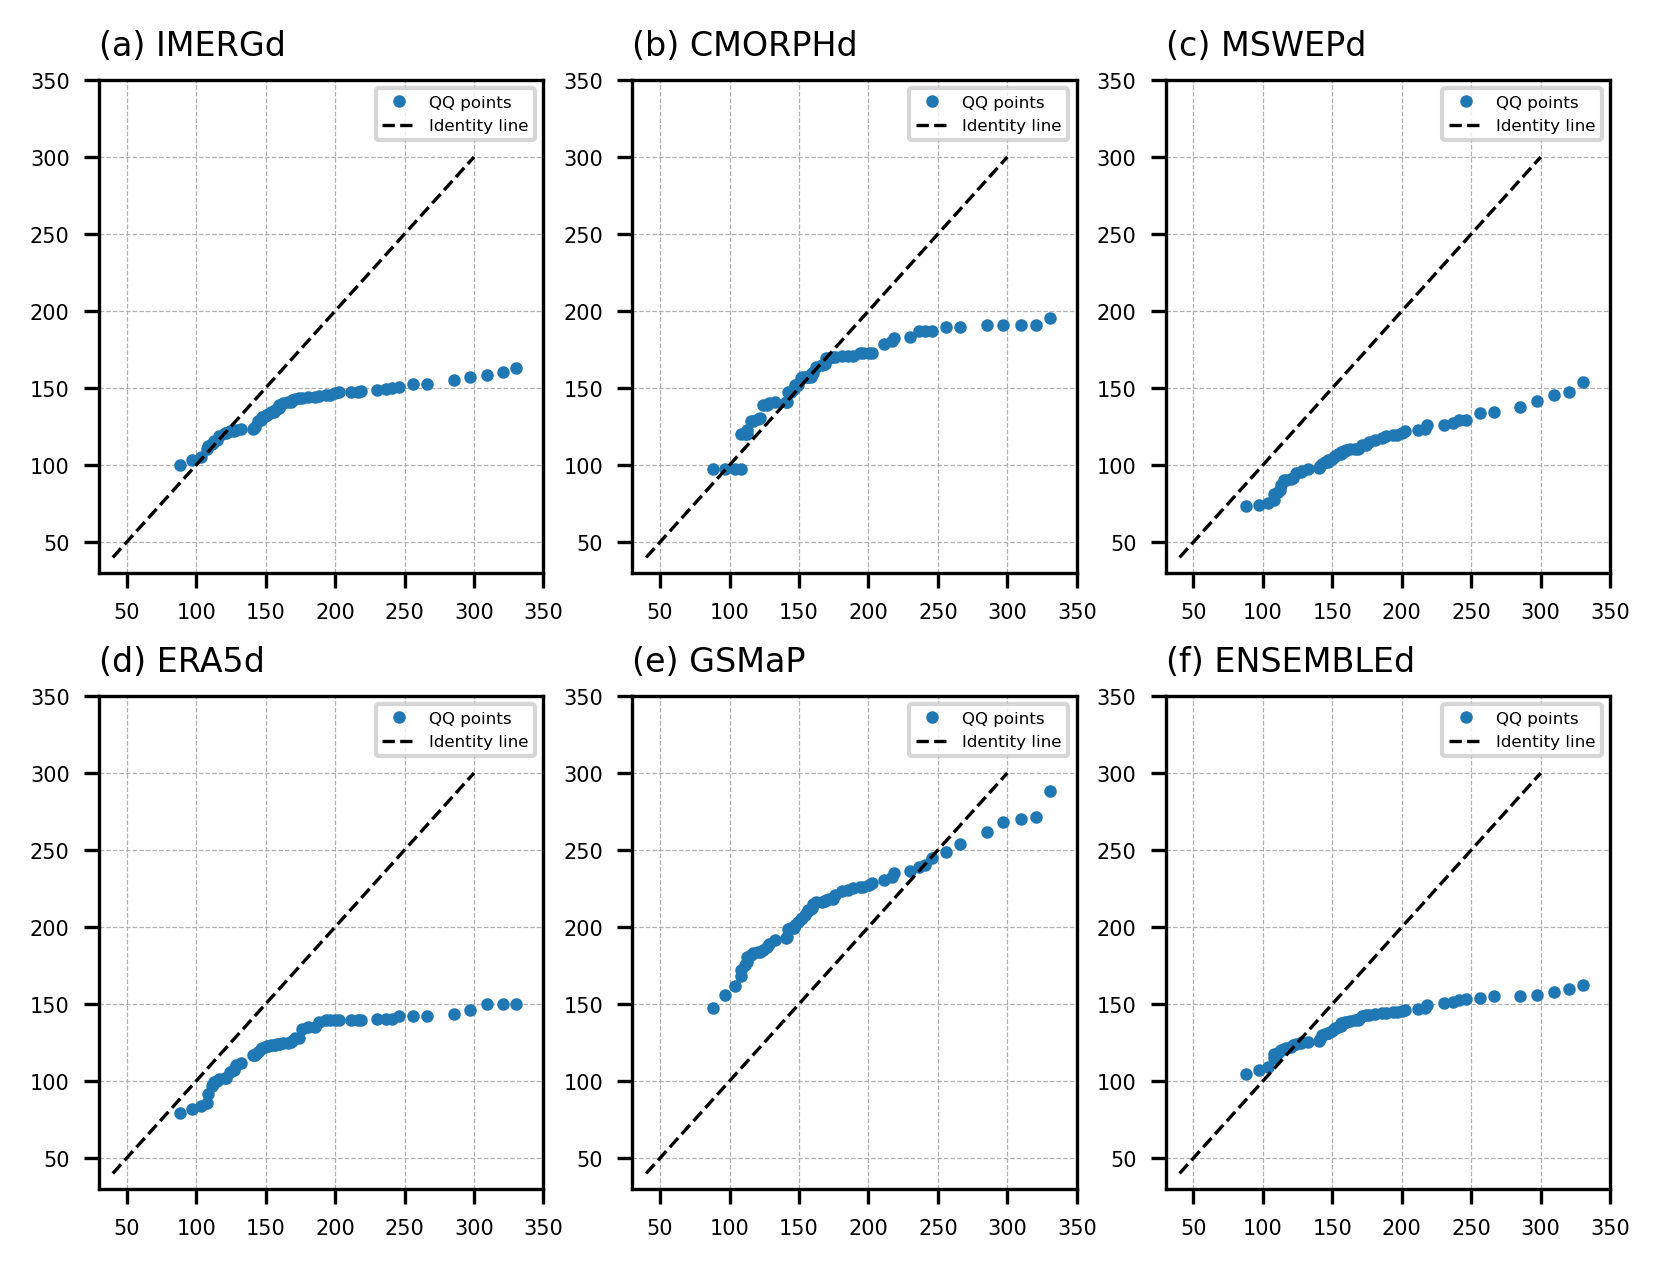

In [329]:
percs = np.linspace(0,100,61)
x = np.linspace(40,300)

fig = plt.figure(figsize=(6.5,4.8),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['IMERGd'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(a) IMERGd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['CMORPHd'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(b) CMORPHd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['MSWEPd'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(c) MSWEPd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 0])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['ERA5d'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(d) ERA5d', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['GSMaPd'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(e) GSMaP', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])

qn_a = np.nanpercentile(SATELLITE_pd['OBS'], percs)
qn_b = np.nanpercentile(SATELLITE_pd['ENSEMBLEd'], percs)
ax1.plot(qn_a,qn_b, ls="", marker="o", markersize=2, label='QQ points')
ax1.plot(x,x, color="k", ls="--", linewidth=0.8, label='Identity line')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('(f) ENSEMBLEd', fontsize=8, loc='left')
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(lmin,lmax)
ax1.set_xlim(lmin,lmax)
ax1.legend(fontsize=4)

# ==============================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.25, wspace=0.2)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Scatter Plot of Weibull Parameters

In [333]:
# # Remove station with problem
# N_df = N_df[N_df['filename']!='003_FG_BS']
# C_df = C_df[C_df['filename']!='003_FG_BS']
# W_df = W_df[W_df['filename']!='003_FG_BS']

In [343]:
N_OBS, C_OBS, W_OBS = [], [], []
N_IMERG, C_IMERG, W_IMERG, Nd_IMERG, Cd_IMERG, Wd_IMERG = [], [], [], [], [], []
for nn in range(len(N_df)):
    lat_obs = N_df['Lat'].values[nn]
    lon_obs = N_df['Lon'].values[nn]

    NOBS_ = N_df.iloc[nn][4:]
    COBS_ = C_df.iloc[nn][4:]
    WOBS_ = W_df.iloc[nn][4:]
    N_OBS.append(NOBS_)
    C_OBS.append(COBS_)
    W_OBS.append(WOBS_)

    distances = ART_pre.haversine(lat_IMERG, lon_IMERG, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    NIMERG_ = NIMERG[:,min_index[0],min_index[1]]
    CIMERG_ = CIMERG[:,min_index[0],min_index[1]]
    WIMERG_ = WIMERG[:,min_index[0],min_index[1]]
    N_IMERG.append(NIMERG_)
    C_IMERG.append(CIMERG_)
    W_IMERG.append(WIMERG_)

    NdIMERG_ = NdIMERG[:,min_index[0],min_index[1]]
    CdIMERG_ = CdIMERG[:,min_index[0],min_index[1]]
    WdIMERG_ = WdIMERG[:,min_index[0],min_index[1]]
    Nd_IMERG.append(NdIMERG_)
    Cd_IMERG.append(CdIMERG_)
    Wd_IMERG.append(WdIMERG_)

N_min = np.nanmin(([np.nanmin(N_OBS),np.nanmin(N_IMERG),np.nanmin(Nd_IMERG)]))
N_max = np.nanmax(([np.nanmax(N_OBS),np.nanmax(N_IMERG),np.nanmax(Nd_IMERG)]))
N_x = np.arange(N_min,N_max+10)

C_min = np.nanmin(([np.nanmin(C_OBS),np.nanmin(C_IMERG),np.nanmin(Cd_IMERG)]))
C_max = np.nanmax(([np.nanmax(C_OBS),np.nanmax(C_IMERG),np.nanmax(Cd_IMERG)]))
C_x = np.arange(C_min,C_max+1)

W_min = np.nanmin(([np.nanmin(W_OBS),np.nanmin(W_IMERG),np.nanmin(Wd_IMERG)]))
W_max = np.nanmax(([np.nanmax(W_OBS),np.nanmax(W_IMERG),np.nanmax(Wd_IMERG)]))
W_x = np.arange(W_min,W_max+0.1)

Text(0.5, 0, 'OBS')

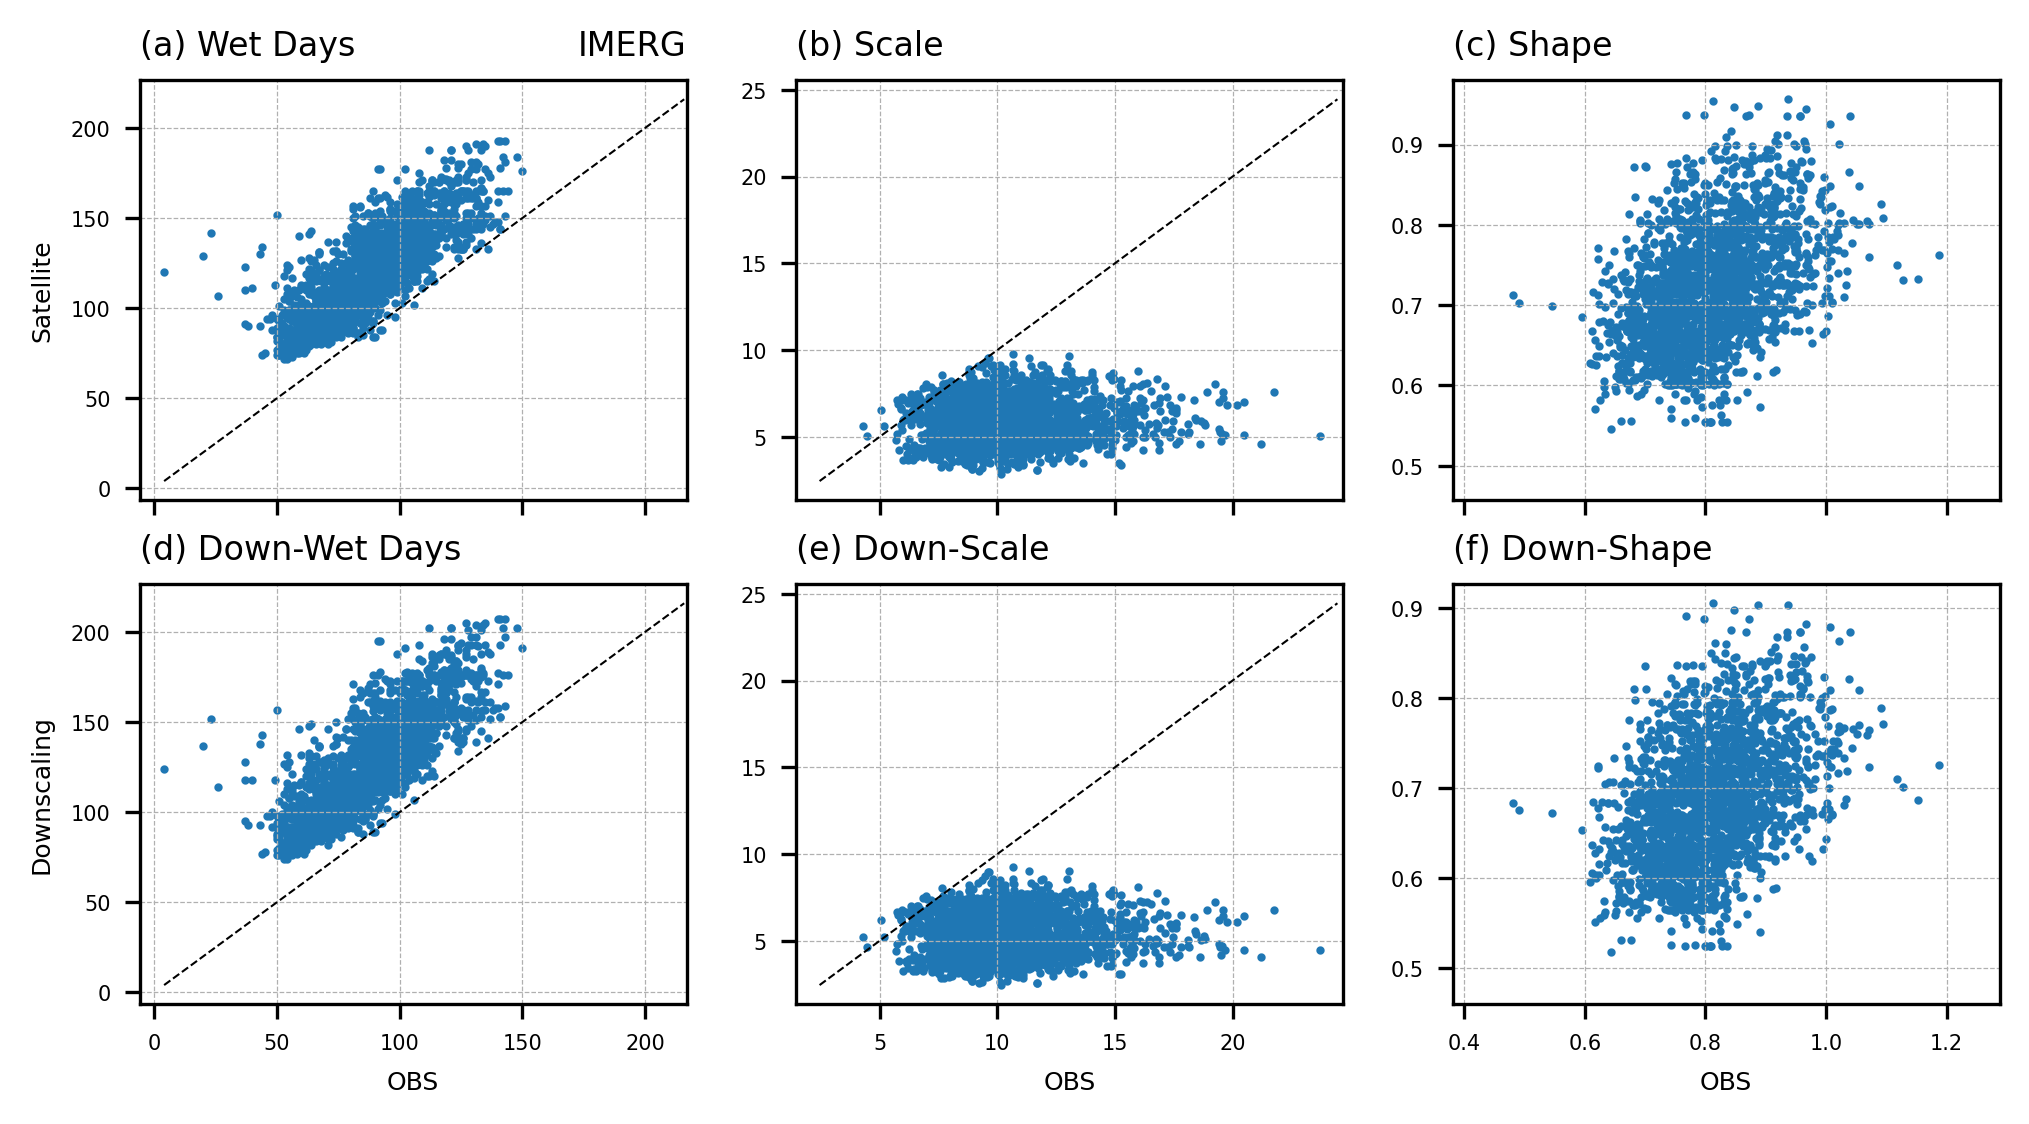

In [344]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(N_OBS,N_IMERG,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title('IMERG', fontsize=8, loc='right')
ax1.set_xticklabels([])
ax1.set_ylabel('Satellite',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(C_OBS,C_IMERG,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(W_OBS,W_IMERG,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(N_OBS,Nd_IMERG,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(d) Down-Wet Days', fontsize=8, loc='left')
ax1.set_ylabel('Downscaling',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(C_OBS,Cd_IMERG,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(e) Down-Scale', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(W_OBS,Wd_IMERG,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(f) Down-Shape', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

In [50]:
# N_OBS, C_OBS, W_OBS = [], [], []
# N_CMORPH, C_CMORPH, W_CMORPH, Nd_CMORPH, Cd_CMORPH, Wd_CMORPH = [], [], [], [], [], []
# for nn in range(len(N_df)):
#     lat_obs = N_df['Lat'].values[nn]
#     lon_obs = N_df['Lon'].values[nn]

#     NOBS_ = N_df.iloc[nn][3:]
#     COBS_ = C_df.iloc[nn][3:]
#     WOBS_ = W_df.iloc[nn][3:]
#     N_OBS.append(NOBS_)
#     C_OBS.append(COBS_)
#     W_OBS.append(WOBS_)

#     distances = ART_pre.haversine(lat_CMORPH, lon_CMORPH, lat_obs, lon_obs)
#     min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

#     NCMORPH_ = NCMORPH[:,min_index[0],min_index[1]]
#     CCMORPH_ = CCMORPH[:,min_index[0],min_index[1]]
#     WCMORPH_ = WCMORPH[:,min_index[0],min_index[1]]
#     N_CMORPH.append(NCMORPH_)
#     C_CMORPH.append(CCMORPH_)
#     W_CMORPH.append(WCMORPH_)

#     NdCMORPH_ = NdCMORPH[:,min_index[0],min_index[1]]
#     CdCMORPH_ = CdCMORPH[:,min_index[0],min_index[1]]
#     WdCMORPH_ = WdCMORPH[:,min_index[0],min_index[1]]
#     Nd_CMORPH.append(NdCMORPH_)
#     Cd_CMORPH.append(CdCMORPH_)
#     Wd_CMORPH.append(WdCMORPH_)

# N_min = np.nanmin(([np.nanmin(N_OBS),np.nanmin(N_CMORPH),np.nanmin(Nd_CMORPH)]))
# N_max = np.nanmax(([np.nanmax(N_OBS),np.nanmax(N_CMORPH),np.nanmax(Nd_CMORPH)]))
# N_x = np.arange(N_min,N_max+10)

# C_min = np.nanmin(([np.nanmin(C_OBS),np.nanmin(C_CMORPH),np.nanmin(Cd_CMORPH)]))
# C_max = np.nanmax(([np.nanmax(C_OBS),np.nanmax(C_CMORPH),np.nanmax(Cd_CMORPH)]))
# C_x = np.arange(C_min,C_max+1)

# W_min = np.nanmin(([np.nanmin(W_OBS),np.nanmin(W_CMORPH),np.nanmin(Wd_CMORPH)]))
# W_max = np.nanmax(([np.nanmax(W_OBS),np.nanmax(W_CMORPH),np.nanmax(Wd_CMORPH)]))
# W_x = np.arange(W_min,W_max+0.1)


In [51]:
# fig = plt.figure(figsize=(8,4),dpi=300)
# gs = gridspec.GridSpec(2,3)

# # ==============================================================================
# # ==============================================================================
# ax1 = plt.subplot(gs[0, 0])
# ax1.scatter(N_OBS,N_CMORPH,s=1)
# ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(N_min-10,N_max+10)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
# ax1.set_title('CMORPH', fontsize=8, loc='right')
# ax1.set_xticklabels([])
# ax1.set_ylabel('Satellite',fontsize=6)

# # ==============================================================================
# ax1 = plt.subplot(gs[0, 1])
# ax1.scatter(C_OBS,C_CMORPH,s=1)
# ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(C_min-1,C_max+1)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(b) Scale', fontsize=8, loc='left')
# ax1.set_xticklabels([])

# # ==============================================================================
# ax1 = plt.subplot(gs[0, 2])
# ax1.scatter(W_OBS,W_CMORPH,s=1)
# ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(W_min-0.1,W_max+0.1)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(c) Shape', fontsize=8, loc='left')
# ax1.set_xticklabels([])

# # ==============================================================================
# # ==============================================================================
# ax1 = plt.subplot(gs[1, 0])
# ax1.scatter(N_OBS,Nd_CMORPH,s=1)
# ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(N_min-10,N_max+10)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(d) Down-Wet Days', fontsize=8, loc='left')
# ax1.set_ylabel('Downscaling',fontsize=6)
# ax1.set_xlabel('OBS',fontsize=6)

# # ==============================================================================
# ax1 = plt.subplot(gs[1, 1])
# ax1.scatter(C_OBS,Cd_CMORPH,s=1)
# ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(C_min-1,C_max+1)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(e) Down-Scale', fontsize=8, loc='left')
# ax1.set_xlabel('OBS',fontsize=6)

# # ==============================================================================
# ax1 = plt.subplot(gs[1, 2])
# ax1.scatter(W_OBS,Wd_CMORPH,s=1)
# ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
# ax1.tick_params(axis='both', which='major', labelsize=5)
# ax1.set_xlim(W_min-0.1,W_max+0.1)
# ax1.grid(linewidth=0.3, linestyle='--')
# ax1.set_title('(f) Down-Shape', fontsize=8, loc='left')
# ax1.set_xlabel('OBS',fontsize=6)

In [346]:
N_OBS, C_OBS, W_OBS = [], [], []
N_ERA5, C_ERA5, W_ERA5, Nd_ERA5, Cd_ERA5, Wd_ERA5 = [], [], [], [], [], []
for nn in range(len(N_df)):
    lat_obs = N_df['Lat'].values[nn]
    lon_obs = N_df['Lon'].values[nn]

    NOBS_ = N_df.iloc[nn][4:]
    COBS_ = C_df.iloc[nn][4:]
    WOBS_ = W_df.iloc[nn][4:]
    N_OBS.append(NOBS_)
    C_OBS.append(COBS_)
    W_OBS.append(WOBS_)

    distances = ART_pre.haversine(lat_ERA5, lon_ERA5, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    NERA5_ = NERA5[:,min_index[0],min_index[1]]
    CERA5_ = CERA5[:,min_index[0],min_index[1]]
    WERA5_ = WERA5[:,min_index[0],min_index[1]]
    N_ERA5.append(NERA5_)
    C_ERA5.append(CERA5_)
    W_ERA5.append(WERA5_)

    NdERA5_ = NdERA5[:,min_index[0],min_index[1]]
    CdERA5_ = CdERA5[:,min_index[0],min_index[1]]
    WdERA5_ = WdERA5[:,min_index[0],min_index[1]]
    Nd_ERA5.append(NdERA5_)
    Cd_ERA5.append(CdERA5_)
    Wd_ERA5.append(WdERA5_)

N_min = np.nanmin(([np.nanmin(N_OBS),np.nanmin(N_ERA5),np.nanmin(Nd_ERA5)]))
N_max = np.nanmax(([np.nanmax(N_OBS),np.nanmax(N_ERA5),np.nanmax(Nd_ERA5)]))
N_x = np.arange(N_min,N_max+10)

C_min = np.nanmin(([np.nanmin(C_OBS),np.nanmin(C_ERA5),np.nanmin(Cd_ERA5)]))
C_max = np.nanmax(([np.nanmax(C_OBS),np.nanmax(C_ERA5),np.nanmax(Cd_ERA5)]))
C_x = np.arange(C_min,C_max+1)

W_min = np.nanmin(([np.nanmin(W_OBS),np.nanmin(W_ERA5),np.nanmin(Wd_ERA5)]))
W_max = np.nanmax(([np.nanmax(W_OBS),np.nanmax(W_ERA5),np.nanmax(Wd_ERA5)]))
W_x = np.arange(W_min,W_max+0.1)

Text(0.5, 0, 'OBS')

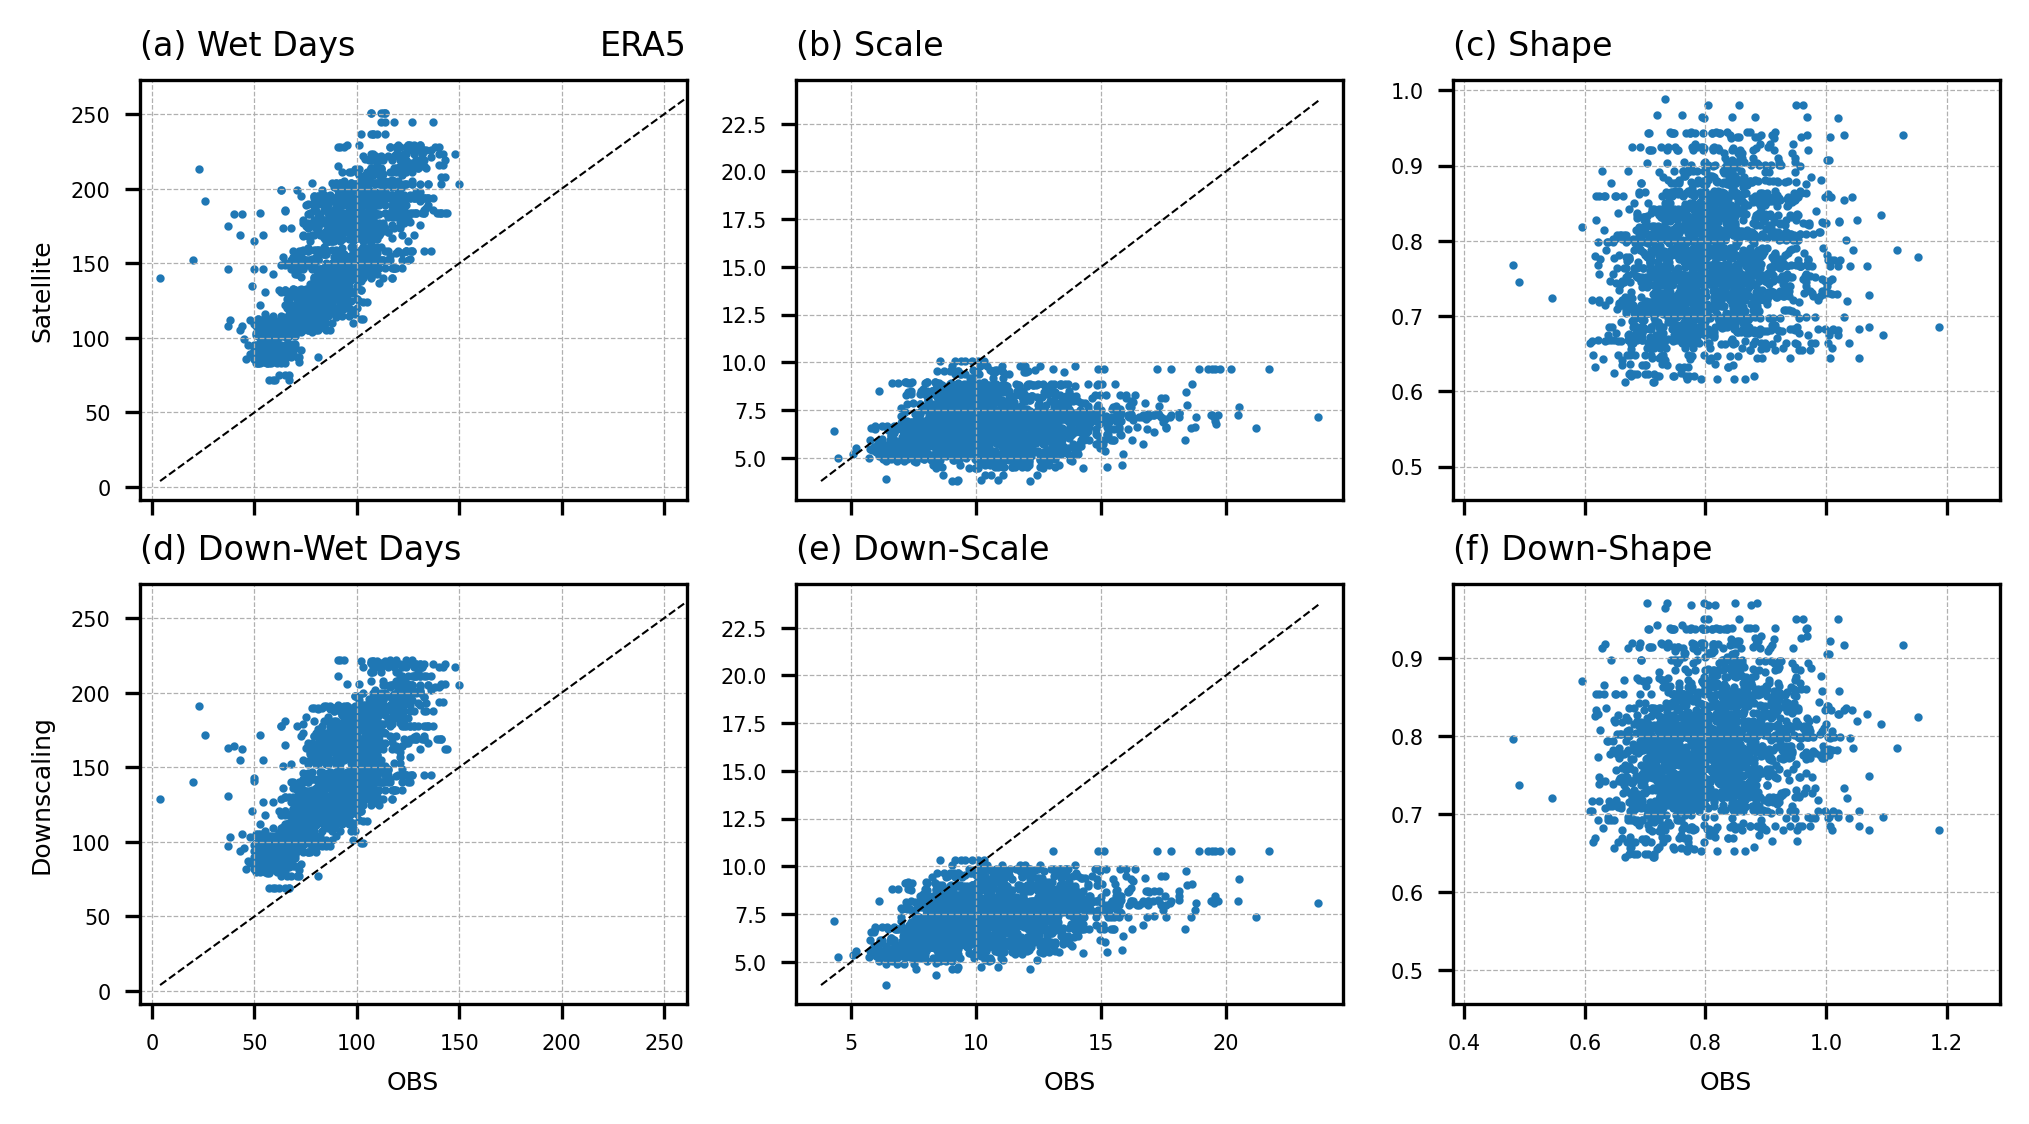

In [347]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(N_OBS,N_ERA5,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title('ERA5', fontsize=8, loc='right')
ax1.set_xticklabels([])
ax1.set_ylabel('Satellite',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(C_OBS,C_ERA5,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(W_OBS,W_ERA5,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(N_OBS,Nd_ERA5,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(d) Down-Wet Days', fontsize=8, loc='left')
ax1.set_ylabel('Downscaling',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(C_OBS,Cd_ERA5,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(e) Down-Scale', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(W_OBS,Wd_ERA5,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(f) Down-Shape', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

In [348]:
N_OBS, C_OBS, W_OBS = [], [], []
N_GSMAP, C_GSMAP, W_GSMAP, Nd_GSMAP, Cd_GSMAP, Wd_GSMAP = [], [], [], [], [], []
for nn in range(len(N_df)):
    lat_obs = N_df['Lat'].values[nn]
    lon_obs = N_df['Lon'].values[nn]

    NOBS_ = N_df.iloc[nn][4:]
    COBS_ = C_df.iloc[nn][4:]
    WOBS_ = W_df.iloc[nn][4:]
    N_OBS.append(NOBS_)
    C_OBS.append(COBS_)
    W_OBS.append(WOBS_)

    distances = ART_pre.haversine(lat_GSMaP, lon_GSMaP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    NGSMAP_ = NGSMAP[:,min_index[0],min_index[1]]
    CGSMAP_ = CGSMAP[:,min_index[0],min_index[1]]
    WGSMAP_ = WGSMAP[:,min_index[0],min_index[1]]
    N_GSMAP.append(NGSMAP_)
    C_GSMAP.append(CGSMAP_)
    W_GSMAP.append(WGSMAP_)

    NdGSMAP_ = NdGSMAP[:,min_index[0],min_index[1]]
    CdGSMAP_ = CdGSMAP[:,min_index[0],min_index[1]]
    WdGSMAP_ = WdGSMAP[:,min_index[0],min_index[1]]
    Nd_GSMAP.append(NdGSMAP_)
    Cd_GSMAP.append(CdGSMAP_)
    Wd_GSMAP.append(WdGSMAP_)

N_min = np.nanmin(([np.nanmin(N_OBS),np.nanmin(N_GSMAP),np.nanmin(Nd_GSMAP)]))
N_max = np.nanmax(([np.nanmax(N_OBS),np.nanmax(N_GSMAP),np.nanmax(Nd_GSMAP)]))
N_x = np.arange(N_min,N_max+10)

C_min = np.nanmin(([np.nanmin(C_OBS),np.nanmin(C_GSMAP),np.nanmin(Cd_GSMAP)]))
C_max = np.nanmax(([np.nanmax(C_OBS),np.nanmax(C_GSMAP),np.nanmax(Cd_GSMAP)]))
C_x = np.arange(C_min,C_max+1)

W_min = np.nanmin(([np.nanmin(W_OBS),np.nanmin(W_GSMAP),np.nanmin(Wd_GSMAP)]))
W_max = np.nanmax(([np.nanmax(W_OBS),np.nanmax(W_GSMAP),np.nanmax(Wd_GSMAP)]))
W_x = np.arange(W_min,W_max+0.1)

Text(0.5, 0, 'OBS')

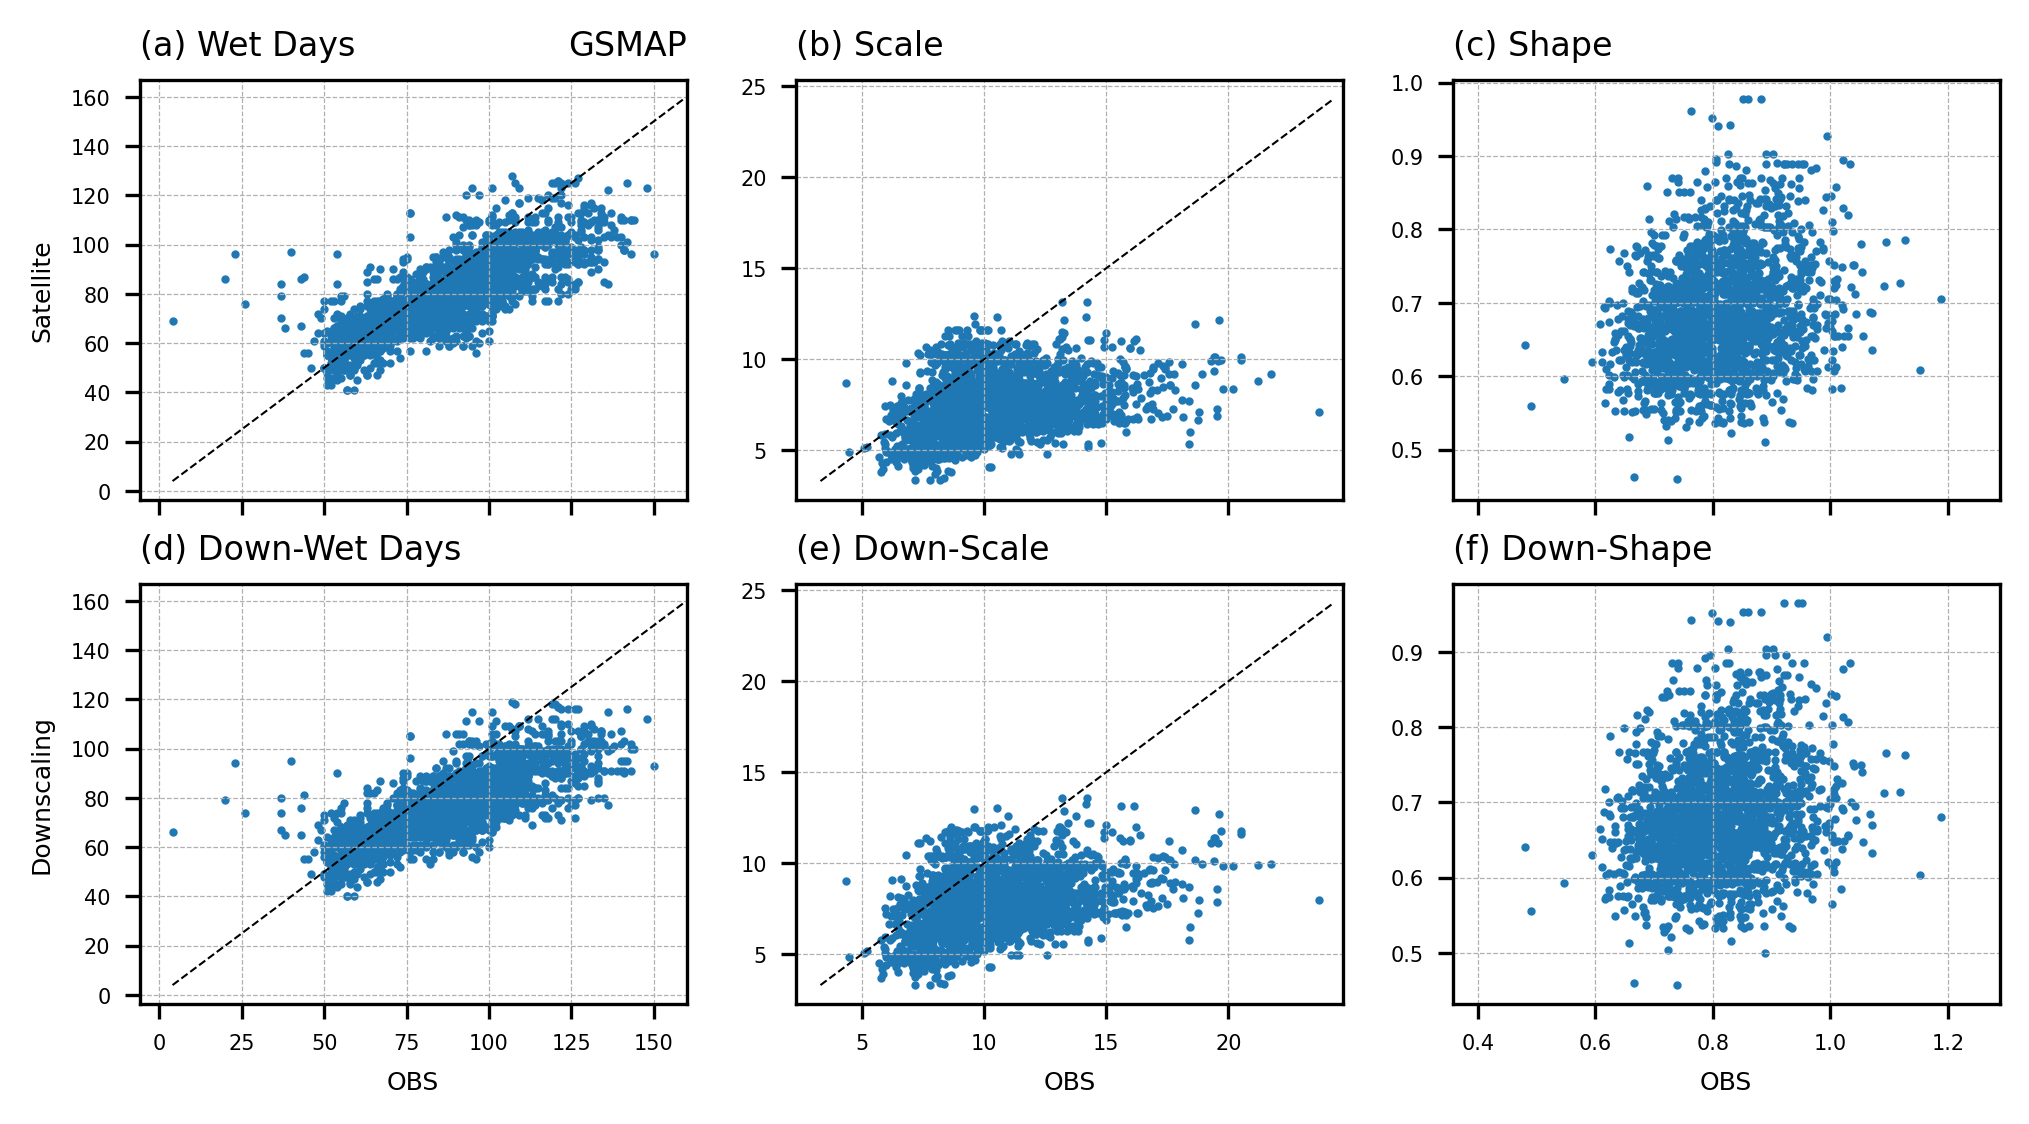

In [349]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(N_OBS,N_GSMAP,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title('GSMAP', fontsize=8, loc='right')
ax1.set_xticklabels([])
ax1.set_ylabel('Satellite',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(C_OBS,C_GSMAP,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(W_OBS,W_GSMAP,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(N_OBS,Nd_GSMAP,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(d) Down-Wet Days', fontsize=8, loc='left')
ax1.set_ylabel('Downscaling',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(C_OBS,Cd_GSMAP,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(e) Down-Scale', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(W_OBS,Wd_GSMAP,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(f) Down-Shape', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

In [350]:
N_OBS, C_OBS, W_OBS = [], [], []
N_MSWEP, C_MSWEP, W_MSWEP, Nd_MSWEP, Cd_MSWEP, Wd_MSWEP = [], [], [], [], [], []
for nn in range(len(N_df)):
    lat_obs = N_df['Lat'].values[nn]
    lon_obs = N_df['Lon'].values[nn]

    NOBS_ = N_df.iloc[nn][4:]
    COBS_ = C_df.iloc[nn][4:]
    WOBS_ = W_df.iloc[nn][4:]
    N_OBS.append(NOBS_)
    C_OBS.append(COBS_)
    W_OBS.append(WOBS_)

    distances = ART_pre.haversine(lat_MSWEP, lon_MSWEP, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    NMSWEP_ = NMSWEP[:,min_index[0],min_index[1]]
    CMSWEP_ = CMSWEP[:,min_index[0],min_index[1]]
    WMSWEP_ = WMSWEP[:,min_index[0],min_index[1]]
    N_MSWEP.append(NMSWEP_)
    C_MSWEP.append(CMSWEP_)
    W_MSWEP.append(WMSWEP_)

    NdMSWEP_ = NdMSWEP[:,min_index[0],min_index[1]]
    CdMSWEP_ = CdMSWEP[:,min_index[0],min_index[1]]
    WdMSWEP_ = WdMSWEP[:,min_index[0],min_index[1]]
    Nd_MSWEP.append(NdMSWEP_)
    Cd_MSWEP.append(CdMSWEP_)
    Wd_MSWEP.append(WdMSWEP_)

N_min = np.nanmin(([np.nanmin(N_OBS),np.nanmin(N_MSWEP),np.nanmin(Nd_MSWEP)]))
N_max = np.nanmax(([np.nanmax(N_OBS),np.nanmax(N_MSWEP),np.nanmax(Nd_MSWEP)]))
N_x = np.arange(N_min,N_max+10)

C_min = np.nanmin(([np.nanmin(C_OBS),np.nanmin(C_MSWEP),np.nanmin(Cd_MSWEP)]))
C_max = np.nanmax(([np.nanmax(C_OBS),np.nanmax(C_MSWEP),np.nanmax(Cd_MSWEP)]))
C_x = np.arange(C_min,C_max+1)

W_min = np.nanmin(([np.nanmin(W_OBS),np.nanmin(W_MSWEP),np.nanmin(Wd_MSWEP)]))
W_max = np.nanmax(([np.nanmax(W_OBS),np.nanmax(W_MSWEP),np.nanmax(Wd_MSWEP)]))
W_x = np.arange(W_min,W_max+0.1)

Text(0.5, 0, 'OBS')

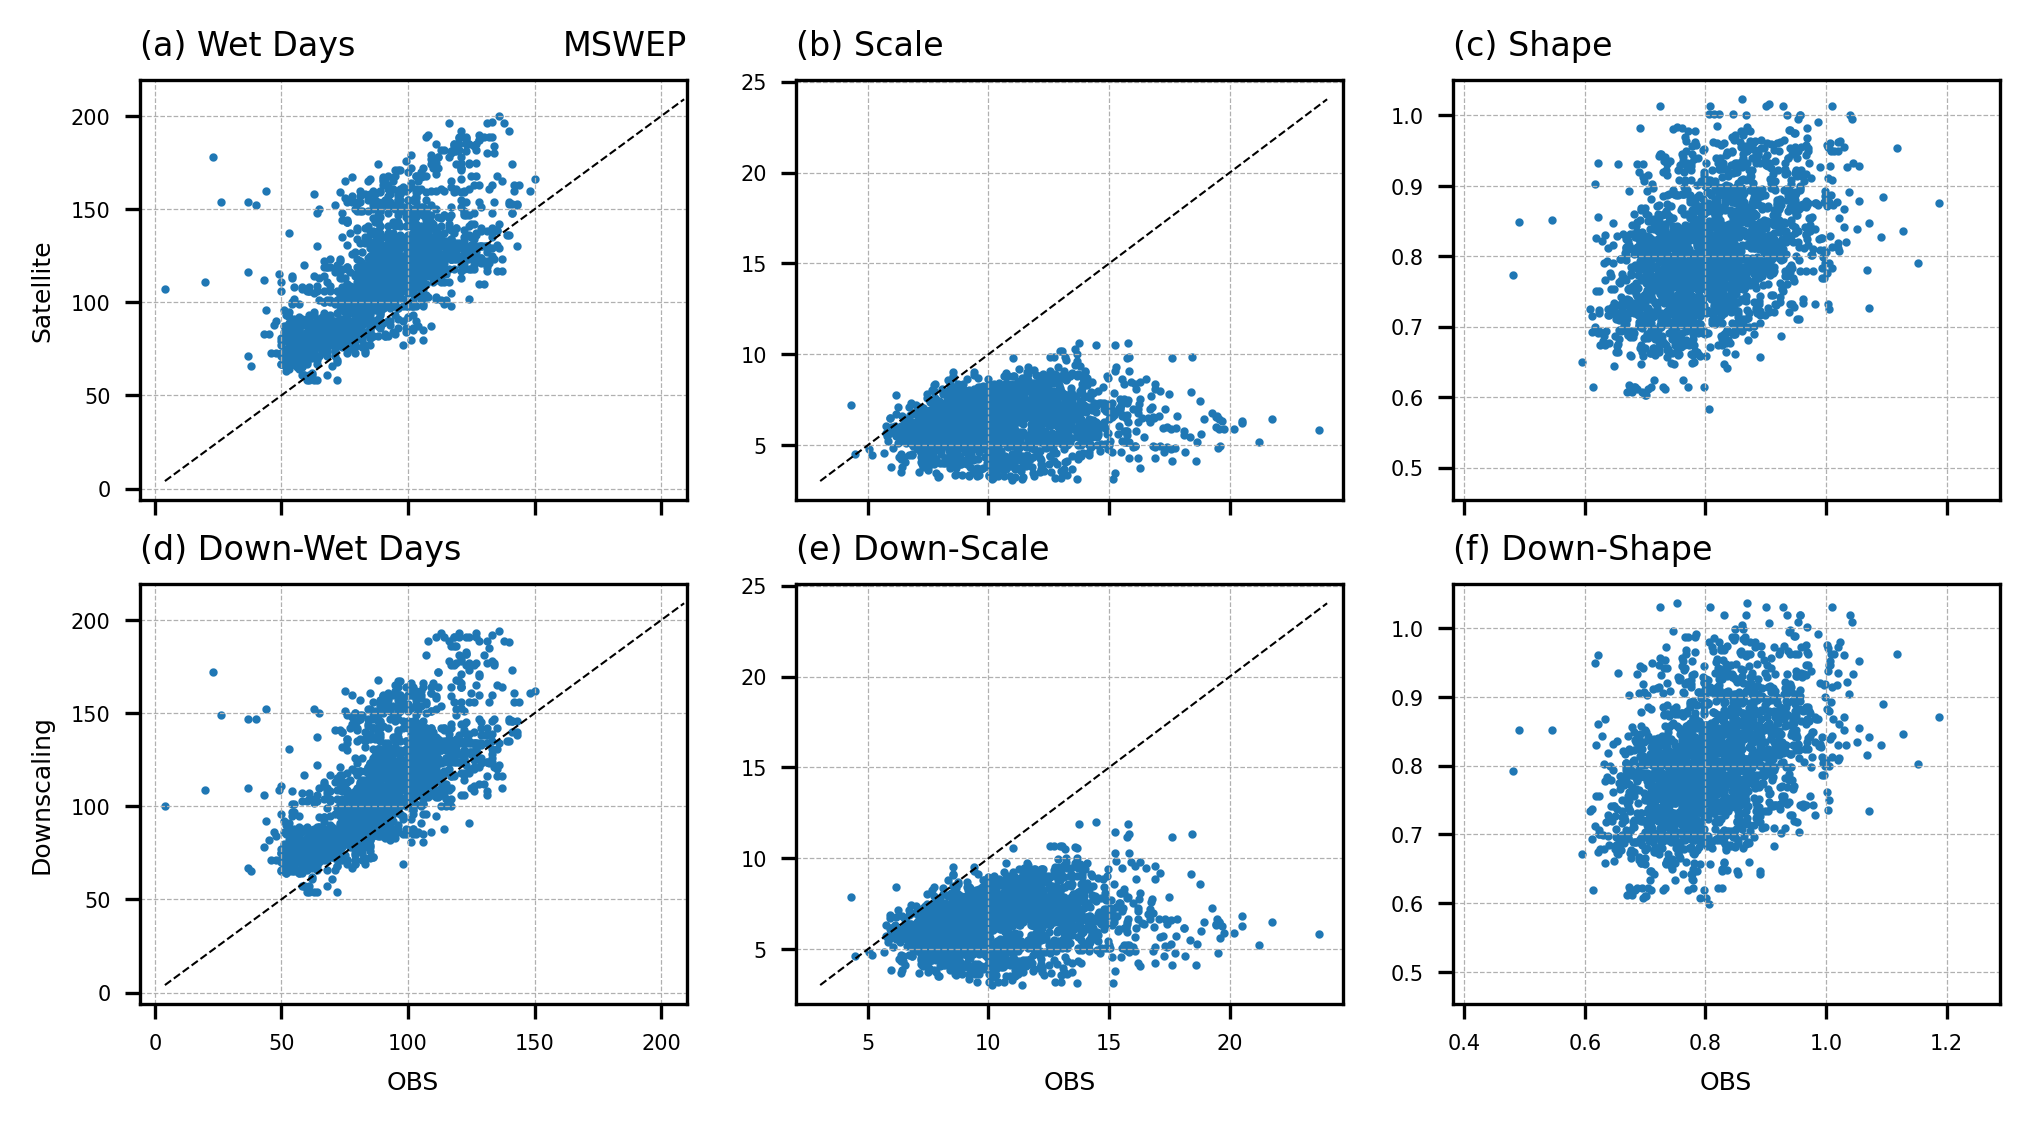

In [351]:
fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(N_OBS,N_MSWEP,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(a) Wet Days', fontsize=8, loc='left')
ax1.set_title('MSWEP', fontsize=8, loc='right')
ax1.set_xticklabels([])
ax1.set_ylabel('Satellite',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
ax1.scatter(C_OBS,C_MSWEP,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(b) Scale', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
ax1.scatter(W_OBS,W_MSWEP,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(c) Shape', fontsize=8, loc='left')
ax1.set_xticklabels([])

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.scatter(N_OBS,Nd_MSWEP,s=1)
ax1.plot(N_x,N_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(N_min-10,N_max+10)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(d) Down-Wet Days', fontsize=8, loc='left')
ax1.set_ylabel('Downscaling',fontsize=6)
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 1])
ax1.scatter(C_OBS,Cd_MSWEP,s=1)
ax1.plot(C_x,C_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(C_min-1,C_max+1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(e) Down-Scale', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

# ==============================================================================
ax1 = plt.subplot(gs[1, 2])
ax1.scatter(W_OBS,Wd_MSWEP,s=1)
ax1.plot(W_x,W_x,'k',linestyle='--',linewidth=0.5)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_xlim(W_min-0.1,W_max+0.1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('(f) Down-Shape', fontsize=8, loc='left')
ax1.set_xlabel('OBS',fontsize=6)

## Mean of area

In [352]:
import shapely.geometry as sg
from shapely.geometry import Point

In [447]:
# lon1, lat1 = 11.6, 45.4
lon1, lat1 = 11.6, 46.2

inc = 0.5
lon_min_rect, lon_max_rect = lon1, lon1 + inc
lat_min_rect, lat_max_rect = lat1, lat1 - inc

# Crear un polígono rectangular
rectangle = sg.Polygon([
    (lon_min_rect, lat_min_rect),
    (lon_max_rect, lat_min_rect),
    (lon_max_rect, lat_max_rect),
    (lon_min_rect, lat_max_rect),
    (lon_min_rect, lat_min_rect)  # Cerrar el polígono
])

rect_gdf = gpd.GeoDataFrame(geometry=[rectangle], crs="EPSG:4326")

In [448]:
wa_gdf = gpd.GeoDataFrame(wa_inside_rect, geometry=gpd.points_from_xy(wa_inside_rect['Lon'], wa_inside_rect['Lat']), crs="EPSG:4326")
wa_inside_rect_test = gpd.sjoin(wa_gdf, rect_gdf, how="inner", predicate="within")
wa_inside_rect_test = wa_inside_rect_test.drop(columns=['index_right'])

QOBS_area_mean = np.nanmean(wa_inside_rect_test.iloc[:,6:-1].values,axis=0)
QOBS_area_mean

array([ 11.        , 152.29936022, 176.79045598, 210.35868105,
       236.92213877, 264.60059637])

In [449]:
def convert_lat_lon_point(lon_in, lat_in):
    lon2d, lat2d = np.meshgrid(lon_in, lat_in)
    points = [Point(lon, lat) for lon, lat in zip(lon2d.ravel(), lat2d.ravel())]
    points_gdf = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")
    
    points_in_rect = gpd.sjoin(points_gdf, rect_gdf, how="inner", predicate="within")
    
    lon_inside = points_in_rect.geometry.x.values  # Longitudes dentro del rectángulo
    lat_inside = points_in_rect.geometry.y.values  # Latitudes dentro del rectángulo
    
    lon_indices = [np.argmin(np.abs(lon_in - lon)) for lon in lon_inside]
    lat_indices = [np.argmin(np.abs(lat_in - lat)) for lat in lat_inside]
    
    lon_indices = np.unique(lon_indices)
    lat_indices = np.unique(lat_indices)
    
    lon2d, lat2d = np.meshgrid(lon_in[lon_indices],lat_in[lat_indices])
    
    return lon_indices, lat_indices, lon2d, lat2d

In [450]:
IMERG_lo_indices, IMERG_la_indices, IMERG_lo_plot, IMERG_la_plot = convert_lat_lon_point(lons_IMERG, lats_IMERG)
CMORPH_lo_indices, CMORPH_la_indices, CMORPH_lo_plot, CMORPH_la_plot = convert_lat_lon_point(lons_CMORPH, lats_CMORPH)
MSWEP_lo_indices, MSWEP_la_indices, MSWEP_lo_plot, MSWEP_la_plot = convert_lat_lon_point(lons_MSWEP, lats_MSWEP)
ERA5_lo_indices, ERA5_la_indices, ERA5_lo_plot, ERA5_la_plot = convert_lat_lon_point(lons_ERA5, lats_ERA5)
GSMaP_lo_indices, GSMaP_la_indices, GSMaP_lo_plot, GSMaP_la_plot = convert_lat_lon_point(lons_GSMaP, lats_GSMaP)

Text(0.0, 1.0, 'GSMaP')

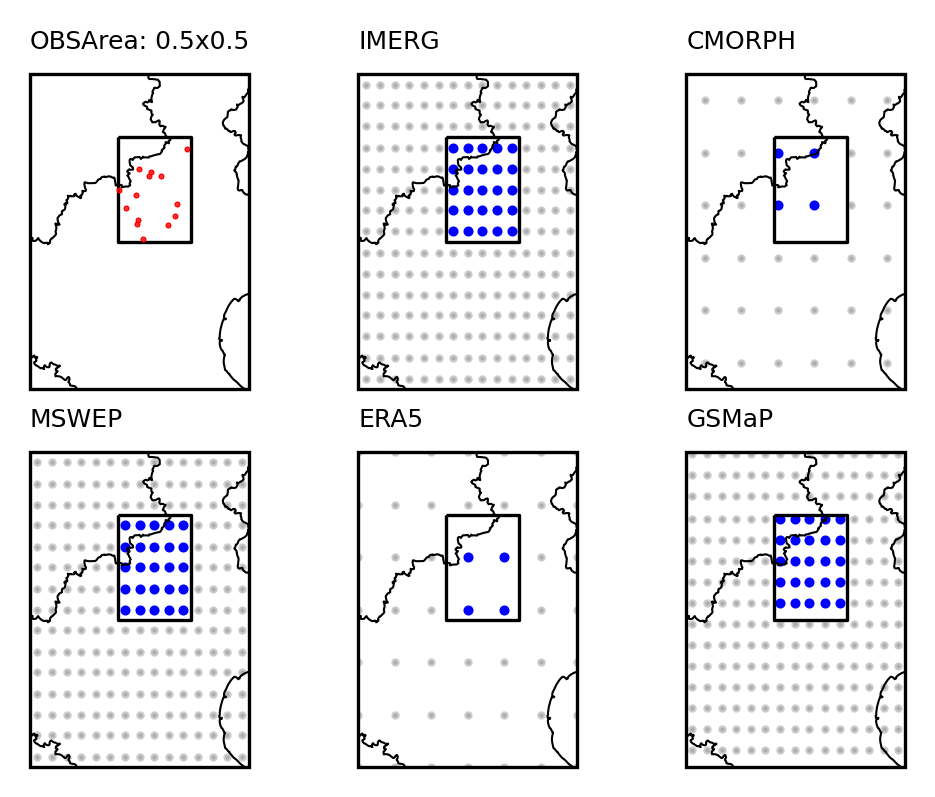

In [451]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,3),dpi=300)
gs = gridspec.GridSpec(2,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(wa_inside_rect_test['Lon'].values, wa_inside_rect_test['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')
ax1.set_title('OBS', fontsize=6, loc='left')
ax1.set_title(f'Area: {inc}x{inc}', fontsize=6, loc='right')

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(lon_IMERG, lat_IMERG,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(IMERG_lo_plot, IMERG_la_plot ,s=2,c='b')
ax1.set_title('IMERG', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(lon_CMORPH, lat_CMORPH,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(CMORPH_lo_plot, CMORPH_la_plot ,s=2,c='b')
ax1.set_title('CMORPH', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(lon_MSWEP, lat_MSWEP,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(MSWEP_lo_plot, MSWEP_la_plot,s=2,c='b')
ax1.set_title('MSWEP', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(lon_ERA5, lat_ERA5,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(ERA5_lo_plot, ERA5_la_plot ,s=2,c='b')
ax1.set_title('ERA5', fontsize=6, loc='left')

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(lon_GSMaP, lat_GSMaP,s=1,c='grey',alpha=0.4)
rect_gdf.plot(ax=ax1, edgecolor='black', facecolor='none', linewidth=0.8, zorder=15)
ax1.scatter(GSMaP_lo_plot, GSMaP_la_plot ,s=2,c='b')
ax1.set_title('GSMaP', fontsize=6, loc='left')

In [452]:
QIMERG_area_mean = np.nanmean(QIMERG[:,IMERG_la_indices[0]:IMERG_la_indices[1]+1,IMERG_lo_indices[0]:IMERG_lo_indices[1]+1],axis=(1,2))

# QCMORPH_area_mean = QCMORPH[:,CMORPH_la_indices[0],CMORPH_lo_indices[0]]
QCMORPH_area_mean = np.nanmean(QCMORPH[:,CMORPH_la_indices[0]:CMORPH_la_indices[1]+1,CMORPH_lo_indices[0]:CMORPH_lo_indices[1]+1],axis=(1,2))

QMSWEP_area_mean = np.nanmean(QMSWEP[:,MSWEP_la_indices[0]:MSWEP_la_indices[1]+1,MSWEP_lo_indices[0]:MSWEP_lo_indices[1]+1],axis=(1,2))

# QERA5_area_mean = QERA5[:,ERA5_la_indices[0],ERA5_lo_indices[0]]
QERA5_area_mean = np.nanmean(QERA5[:,ERA5_la_indices[0]:ERA5_la_indices[1]+1,ERA5_lo_indices[0]:ERA5_lo_indices[1]+1],axis=(1,2))

QGSMaP_area_mean = np.nanmean(QGSMaP[:,GSMaP_la_indices[0]:GSMaP_la_indices[1]+1,GSMaP_lo_indices[0]:GSMaP_lo_indices[1]+1],axis=(1,2))

# QENSEMBLE = np.nanmean([QIMERG_area_mean, QCMORPH_area_mean, QMSWEP_area_mean, QERA5_area_mean, QGSMaP_area_mean],axis=0)
QENSEMBLE = np.nanmean([QMSWEP_area_mean, QERA5_area_mean, QGSMaP_area_mean],axis=0)

In [453]:
QdIMERG_area_mean = np.nanmean(QdIMERG[:,IMERG_la_indices[0]:IMERG_la_indices[1]+1,IMERG_lo_indices[0]:IMERG_lo_indices[1]+1],axis=(1,2))
QdCMORPH_area_mean = QdCMORPH[:,CMORPH_la_indices[0],CMORPH_lo_indices[0]]
QdMSWEP_area_mean = np.nanmean(QdMSWEP[:,MSWEP_la_indices[0]:MSWEP_la_indices[1]+1,MSWEP_lo_indices[0]:MSWEP_lo_indices[1]+1],axis=(1,2))
QdERA5_area_mean = QdERA5[:,ERA5_la_indices[0],ERA5_lo_indices[0]]
QdGSMaP_area_mean = np.nanmean(QdGSMaP[:,GSMaP_la_indices[0]:GSMaP_la_indices[1]+1,GSMaP_lo_indices[0]:GSMaP_lo_indices[1]+1],axis=(1,2))

# QdENSEMBLE = np.nanmean([QdIMERG_area_mean, QdCMORPH_area_mean, QdMSWEP_area_mean, QdERA5_area_mean, QdGSMaP_area_mean],axis=0)
QdENSEMBLE = np.nanmean([QdMSWEP_area_mean, QdERA5_area_mean, QdGSMaP_area_mean],axis=0)

In [454]:
Tr = ([ 5, 10,  20,  50, 100, 200])

(40.0, 302.01657938977115)

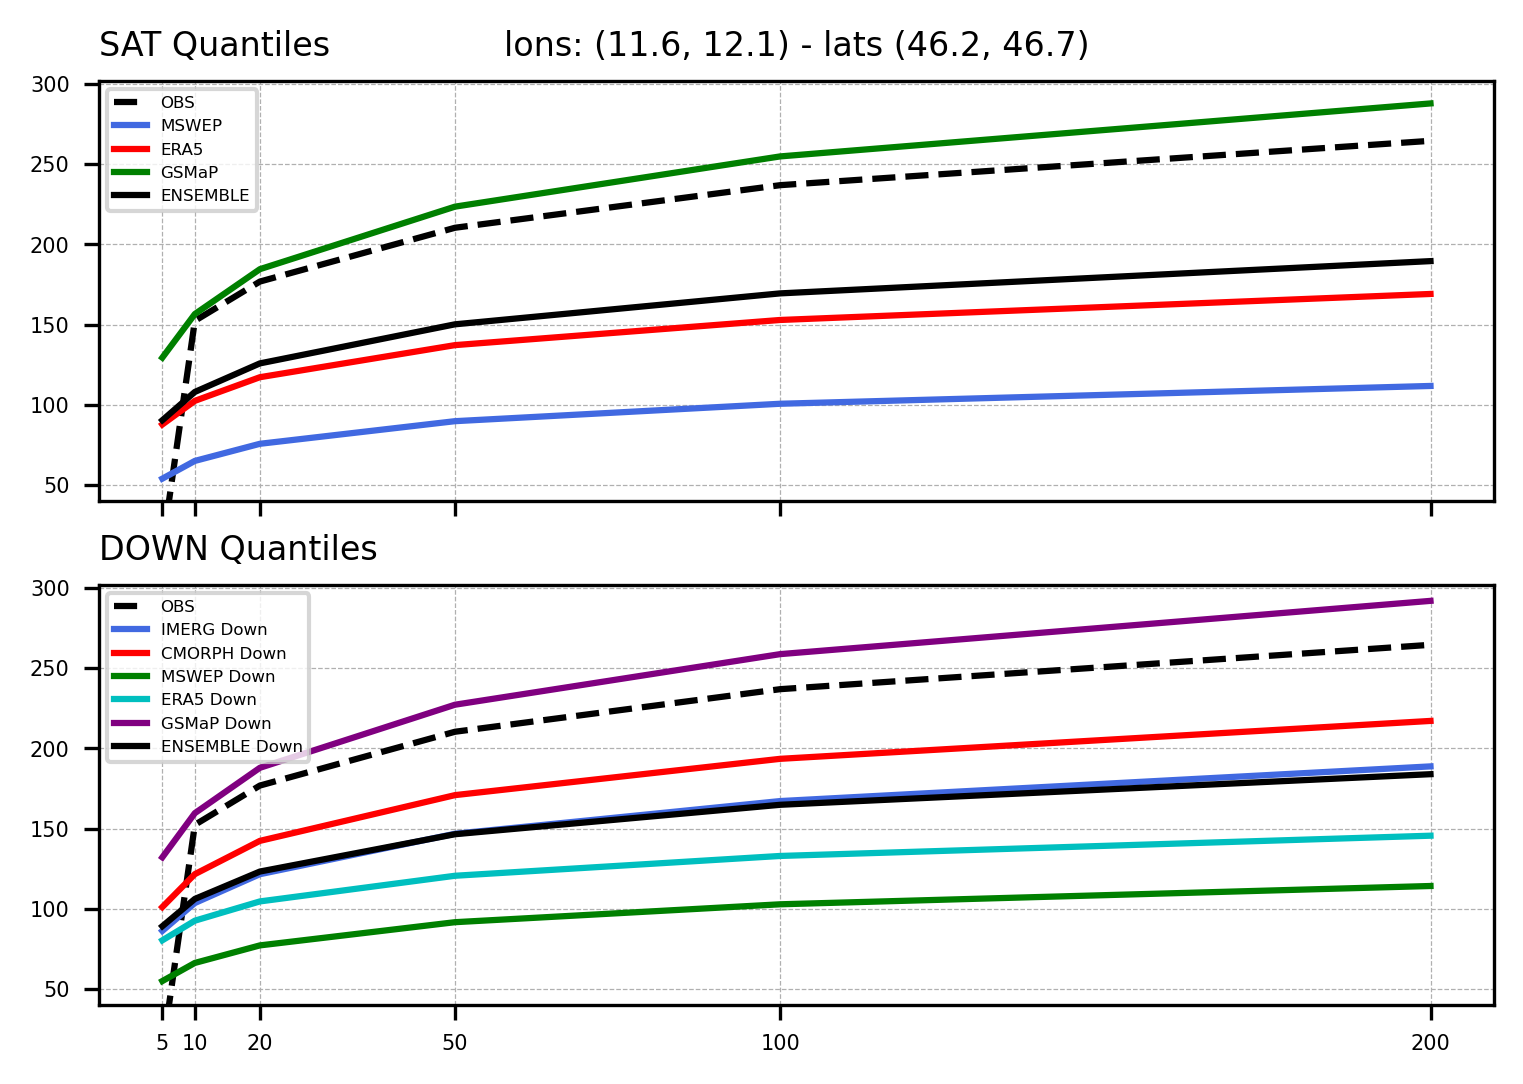

In [456]:
fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,1)

max_d = np.max([np.nanmax(QdMSWEP_area_mean), np.nanmax(QdERA5_area_mean), np.nanmax(QdGSMaP_area_mean)])
max_s = np.max([np.nanmax(QMSWEP_area_mean), np.nanmax(QERA5_area_mean), np.nanmax(QGSMaP_area_mean)])
max_t = np.max([max_d, max_s])

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0])
ax1.plot(Tr, QOBS_area_mean, '--k', label='OBS')

# ax1.plot(Tr, QIMERG_area_mean, label='IMERG')
# ax1.plot(Tr, QCMORPH_area_mean, label='CMORPH')
ax1.plot(Tr, QMSWEP_area_mean, color=colors[0], label='MSWEP')
ax1.plot(Tr, QERA5_area_mean, color=colors[1], label='ERA5')
ax1.plot(Tr, QGSMaP_area_mean, color=colors[2], label='GSMaP')

ax1.plot(Tr, QENSEMBLE, '-k', label='ENSEMBLE')

ax1.legend(fontsize=4)
ax1.grid(linewidth=0.3,linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('SAT Quantiles', fontsize=8, loc='left')
ax1.set_title(acf, fontsize=8, loc='center')
ax1.set_title(f'lons: {lon1,lon1+inc} - lats {lat1,lat1+inc}', fontsize=8, loc='center')

ax1.set_xticks(Tr)
ax1.set_xticklabels([])
ax1.set_ylim(40, max_t+10)

# ============================================================================================================================
ax1 = plt.subplot(gs[1, 0])
ax1.plot(Tr, QOBS_area_mean, '--k', label='OBS')

# ax1.plot(Tr, QMSWEP_area_mean, color=colors[0], alpha=0.3)
# ax1.plot(Tr, QERA5_area_mean, color=colors[1], alpha=0.3)
# ax1.plot(Tr, QGSMaP_area_mean, color=colors[2], alpha=0.3)

ax1.plot(Tr, QdIMERG_area_mean, color=colors[0], label='IMERG Down')
ax1.plot(Tr, QdCMORPH_area_mean, color=colors[1], label='CMORPH Down')
ax1.plot(Tr, QdMSWEP_area_mean, color=colors[2], label='MSWEP Down')
ax1.plot(Tr, QdERA5_area_mean, color=colors[3], label='ERA5 Down')
ax1.plot(Tr, QdGSMaP_area_mean, color=colors[5], label='GSMaP Down')

ax1.plot(Tr, QdENSEMBLE, '-k', label='ENSEMBLE Down')

ax1.legend(fontsize=4)
ax1.grid(linewidth=0.3,linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.set_title('DOWN Quantiles', fontsize=8, loc='left')

ax1.set_xticks(Tr)
ax1.set_ylim(40, max_t+10)